# Project S14 - Aprendizaje Automático para Textos

## 1 Descripción del Proyecto

Film Junky Union, una nueva comunidad vanguardista para los aficionados de las películas clásicas, está desarrollando un sistema para filtrar y categorizar reseñas de películas. Tu objetivo es entrenar un modelo para detectar las críticas negativas de forma automática. Para lograrlo, utilizarás un conjunto de datos de reseñas de películas de IMDB con etiquetado para construir un modelo que clasifique las reseñas como positivas y negativas. Este deberá alcanzar un valor F1 de al menos 0.85.

`Objetivo`:
- Tu objetivo es entrenar un modelo para detectar las críticas negativas de forma automática.

### 1.1 Instrucciones del Proyecto

Para realizar el proyecto deberás completar los siguientes pasos: 

1. Carga los datos.
2. Preprocesa los datos, si es necesario.
3. Realiza un análisis exploratorio de datos y haz tu conclusión sobre el desequilibrio de clases.
4. Realiza el preprocesamiento de datos para el modelado.
5. Entrena al menos tres modelos diferentes para el conjunto de datos de entrenamiento.
6. Prueba los modelos para el conjunto de datos de prueba.
7. Escribe algunas reseñas y clasifícalas con todos los modelos.
8. Busca las diferencias entre los resultados de las pruebas de los modelos en los dos puntos anteriores. Intenta explicarlas.
9. Muestra tus hallazgos.

Tu trabajo principal es `construir y evaluar modelos`.

Como puedes ver, te sugerimos probar modelos de clasificación basados en `regresión logística` y `potenciación del gradiente`, pero puedes probar otros métodos.

### 1.2 Descripción de los Datos

Los datos se almacenan en el archivo `imdb_reviews.tsv`. Descargar el conjunto de datos.

Los datos fueron proporcionados por Andrew L. Maas, Raymond E. Daly, Peter T. Pham, Dan Huang, Andrew Y. Ng, y Christopher Potts. (2011). Learning Word Vectors for Sentiment Analysis. La Reunión Anual 49 de la Asociación de Lingüística Computacional (ACL 2011).

Aquí se describen los campos seleccionados:

- `review`: el texto de la reseña
- `pos`: el objetivo, '0' para negativo y '1' para positivo
- `ds_part`: 'entrenamiento'/'prueba' para la parte de entrenamiento/prueba del conjunto de datos, respectivamente

Hay otros campos en el conjunto de datos, puedes explorarlos si lo deseas.

## 2 Pre-Procesamiento de Datos

### 2.1 Importar Librerías

In [1]:
import math

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

import sklearn.metrics as metrics
from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

import re
import spacy

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
%config InlineBackend.figure_format = 'png'

# Better quality graphics on HiDPI screens
%config InlineBackend.figure_format = 'retina'

#plt.style.use('seaborn')

### 2.2 Cargar y Leer los Datos

In [2]:
# Cargar los datos
df_reviews = pd.read_csv('imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

In [3]:
# Comprobar la información 
df_reviews.sample(5)

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
33121,tt0044091,movie,Superman and the Mole-Men,Superman and the Mole-Men,1951,\N,58,0,"Action,Adventure,Drama",5.7,1683,I rented this film from Netflix for two reason...,7,pos,1,train,2575
46690,tt0420324,short,World's Finest,World's Finest,2004,\N,4,0,"Action,Short",6.9,739,"""World's Finest"" is an unique project. It's a ...",7,pos,1,train,5946
14445,tt0238784,tvSeries,Gilmore Girls,Gilmore Girls,2000,2007,44,0,"Comedy,Drama",8.1,93623,People need to give this show a chance. The pe...,10,pos,1,test,3211
20305,tt0190524,video,Left Behind: The Movie,Left Behind,2000,\N,96,0,"Action,Drama,Fantasy",4.5,8845,What is it with Americans and their hang-up wi...,2,neg,0,train,6009
24793,tt0349903,movie,Ocean's Twelve,Ocean's Twelve,2004,\N,125,0,"Crime,Thriller",6.5,349053,Ocean's 12 starts off on annoying and gets wor...,1,neg,0,test,280


In [52]:
# Leer la información general
print('Data Description')
display(df_reviews.describe(include='all').T)
print('='*120)
print('General Information')
display(df_reviews.info())

Data Description


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
tconst,47329,6647,tt0386741,30,NaN,NaN,NaN,NaN,NaN,NaN,NaN
title_type,47329,10,movie,36859,NaN,NaN,NaN,NaN,NaN,NaN,NaN
primary_title,47329,6554,The Sentinel,60,NaN,NaN,NaN,NaN,NaN,NaN,NaN
original_title,47329,6561,The Sentinel,60,NaN,NaN,NaN,NaN,NaN,NaN,NaN
start_year,47329.0,NaN,NaN,NaN,1989.630882,19.600702,1894.0,1982.0,1998.0,2004.0,2010.0
end_year,47329,60,\N,45050,NaN,NaN,NaN,NaN,NaN,NaN,NaN
runtime_minutes,47329,249,90,2442,NaN,NaN,NaN,NaN,NaN,NaN,NaN
is_adult,47329.0,NaN,NaN,NaN,0.001733,0.041588,0.0,0.0,0.0,0.0,1.0
genres,47329,585,Drama,3392,NaN,NaN,NaN,NaN,NaN,NaN,NaN
average_rating,47329.0,NaN,NaN,NaN,5.998278,1.494289,1.4,5.1,6.3,7.1,9.7


General Information
<class 'pandas.core.frame.DataFrame'>
Index: 47329 entries, 0 to 47330
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47329 non-null  object 
 1   title_type       47329 non-null  object 
 2   primary_title    47329 non-null  object 
 3   original_title   47329 non-null  object 
 4   start_year       47329 non-null  int64  
 5   end_year         47329 non-null  object 
 6   runtime_minutes  47329 non-null  object 
 7   is_adult         47329 non-null  int64  
 8   genres           47329 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47329 non-null  object 
 12  rating           47329 non-null  int64  
 13  sp               47329 non-null  object 
 14  pos              47329 non-null  int64  
 15  ds_part          47329 non-null  object 
 16  idx              47329 non-null  int64  
 1

None

**Hallazgos:**
- El conjunto de datos contiene un total de 18 columnas y 47,329 filas de datos.
- La mayoría de las columnas son categóricas y son de tipo "object".
- Los datos de las películas abarcan desde el año 1894 hasta 2010.
- El valor promedio de la columna `average_rating` es aproximadamente 6, con una mediana de 6.3. La calificación más baja es 1.4 y la más alta es 9.7.
- El valor promedio de la columna `rating` es 5.48, pero la mediana es 4.0, lo que indica la presencia de un valor atípico.
- El conjunto de datos incluye datos mixtos de entrenamiento y prueba, identificados en la columna `ds_part`.
- En general, se considera que la calidad de los datos es suficientemente buena.

In [5]:
# Eliminar las filas con valores ausentes
df_reviews = df_reviews.dropna()
df_reviews.isna().sum()

tconst             0
title_type         0
primary_title      0
original_title     0
start_year         0
end_year           0
runtime_minutes    0
is_adult           0
genres             0
average_rating     0
votes              0
review             0
rating             0
sp                 0
pos                0
ds_part            0
idx                0
dtype: int64

## 3 Análisis Exploratorio de los Datos

Realizaremos un análisis exploratorio de datos para obtener información sobre las tendencias generales en este conjunto de datos. Nuestro análisis incluirá examinar el número de películas y reseñas a lo largo de los años, explorar la distribución del número de reseñas por película y evaluar el equilibrio de clases dentro de los datos.

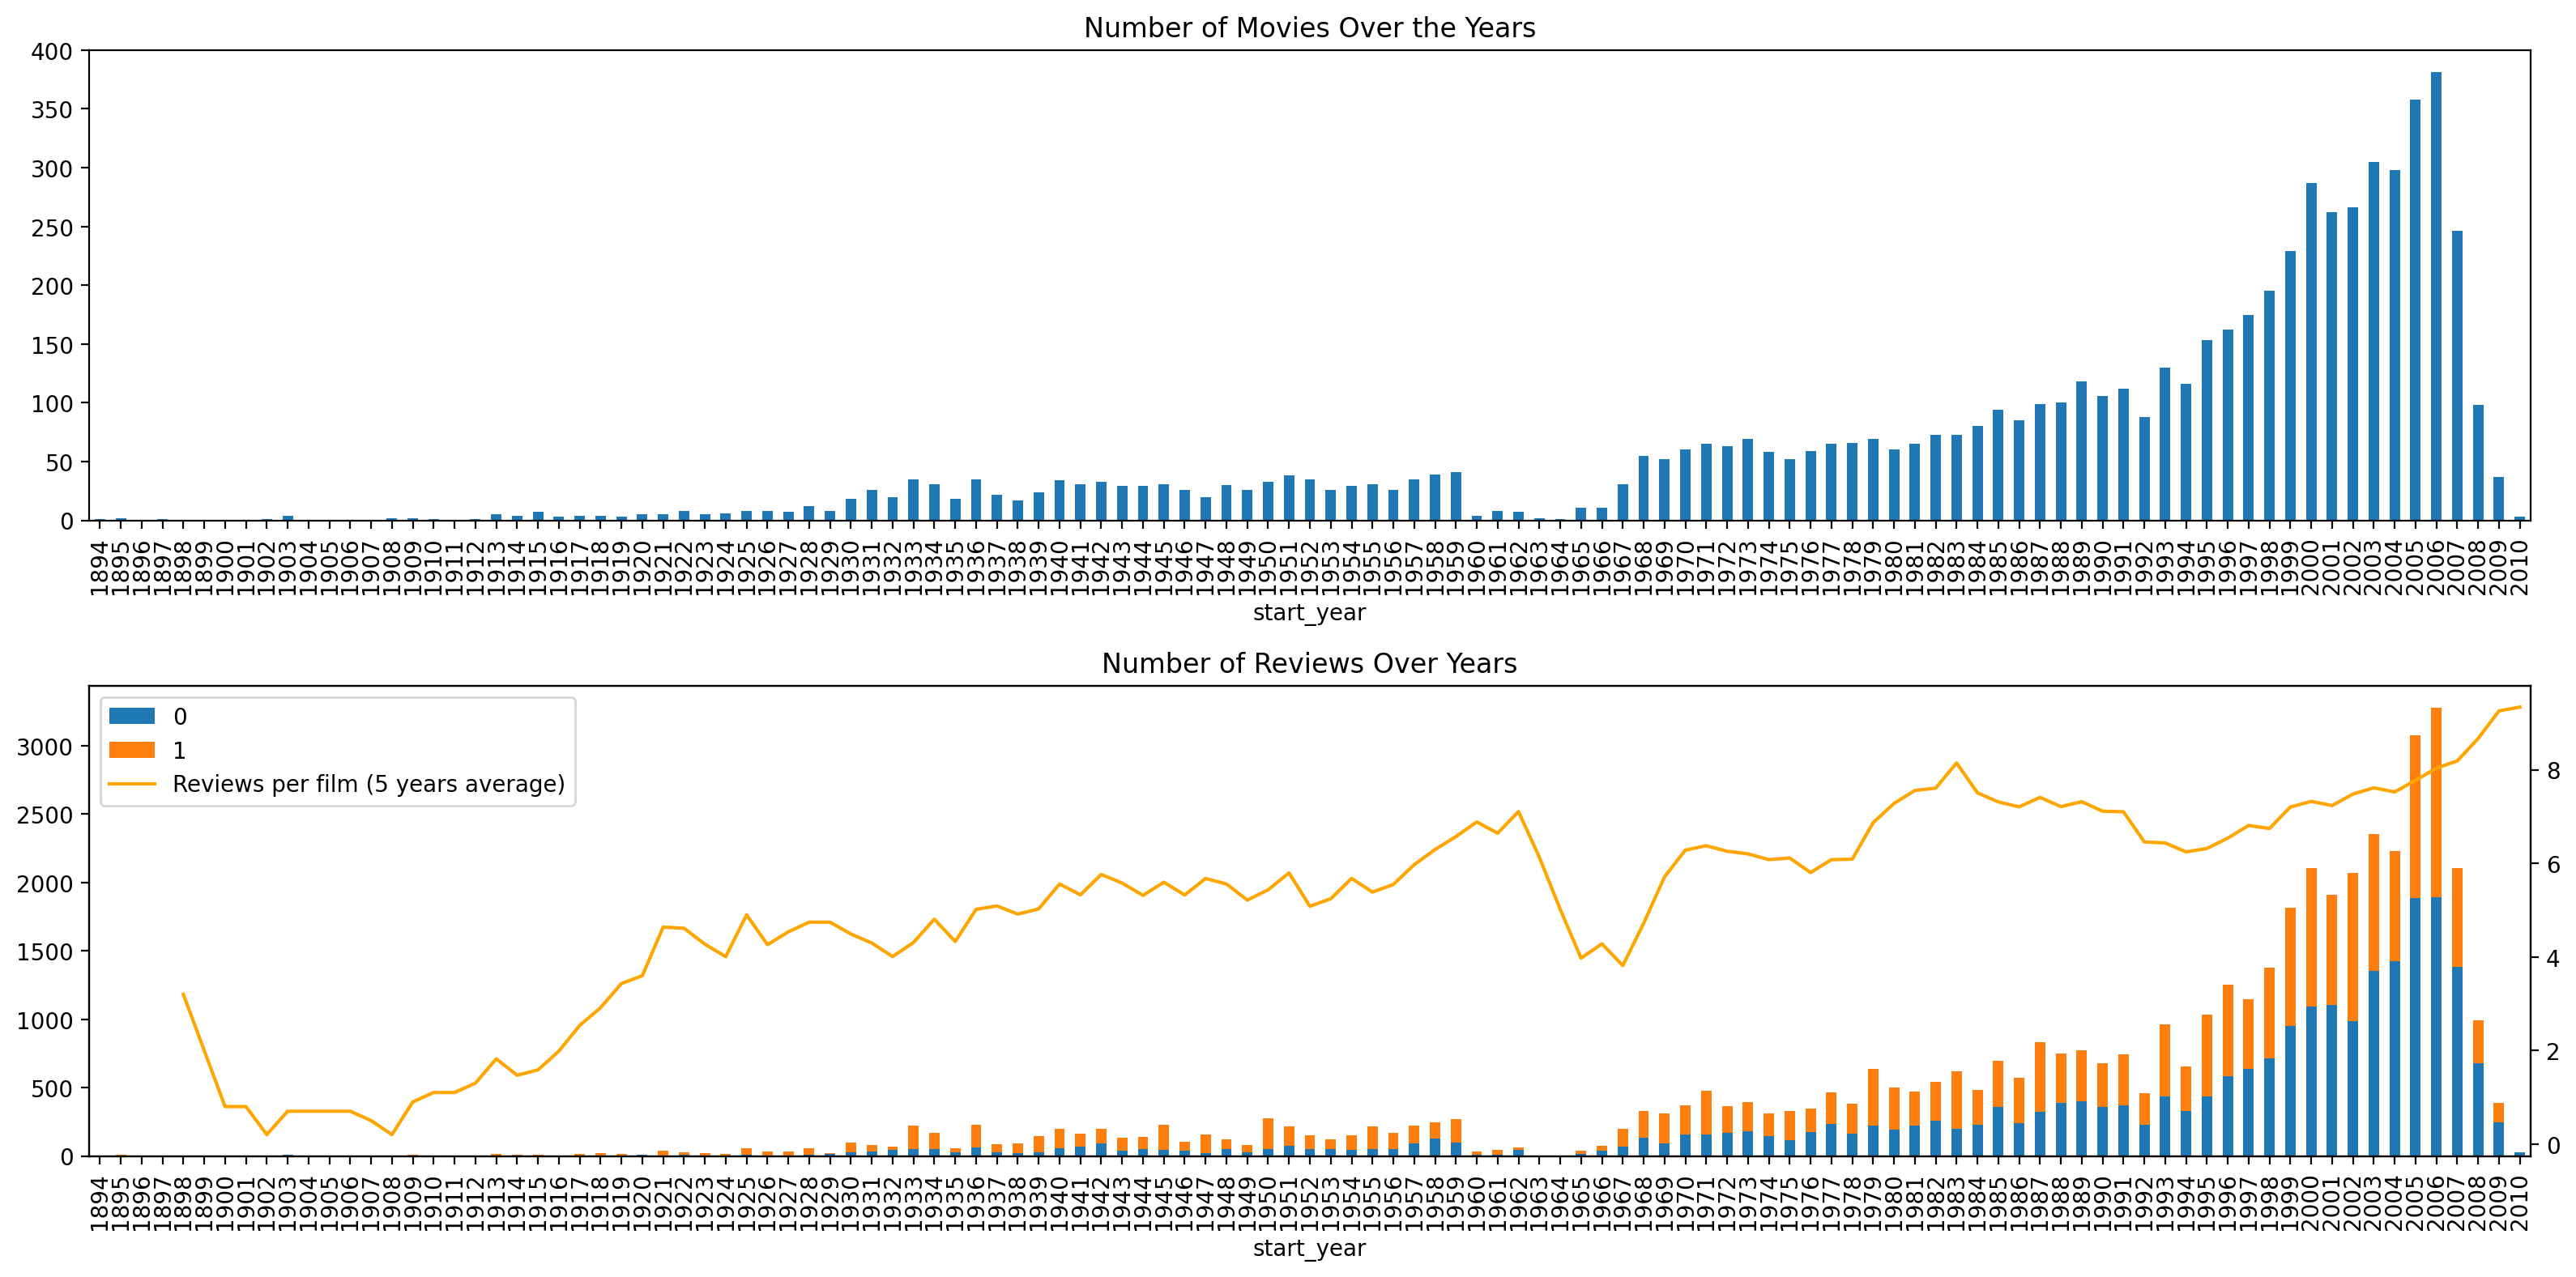

In [6]:
# Comprobar el número de películas y reseñas a través de los años
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2011))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Number of Movies Over the Years')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2011))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='Review  (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2011))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', 
                                                   label='Reviews per film (5 years average)', ax=axt)

lines1, labels1 = ax.get_legend_handles_labels()
lines2, labels2 = axt.get_legend_handles_labels()
ax.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

ax.set_title('Number of Reviews Over Years') 

fig.tight_layout()

**Hallazgos:**
- El número de películas ha ido aumentando constantemente en la última década.
- Hubo una disminución en el número de películas durante la década de 1960, pero desde la década de 1970 ha habido un aumento significativo.
- La producción cinematográfica muestra una disminución después de 2006, pero esto podría deberse a los plazos de recopilación de datos.
- La tendencia en el número de reseñas también sigue el patrón del número de películas a lo largo de los años.
- Sin embargo, no hubo un aumento significativo en el número de reseñas durante las décadas de 1990 y 2000, a pesar del rápido incremento en el número de películas durante ese período.

A continuación, analizaremos la distribución del número de reseñas por película con conteos precisos. Además, utilizaremos gráficos de KDE (Estimación de Densidad de Núcleo) para visualizar las diferencias con respecto a los cálculos exactos. El gráfico de KDE proporciona una representación de la densidad de probabilidad de una variable aleatoria.

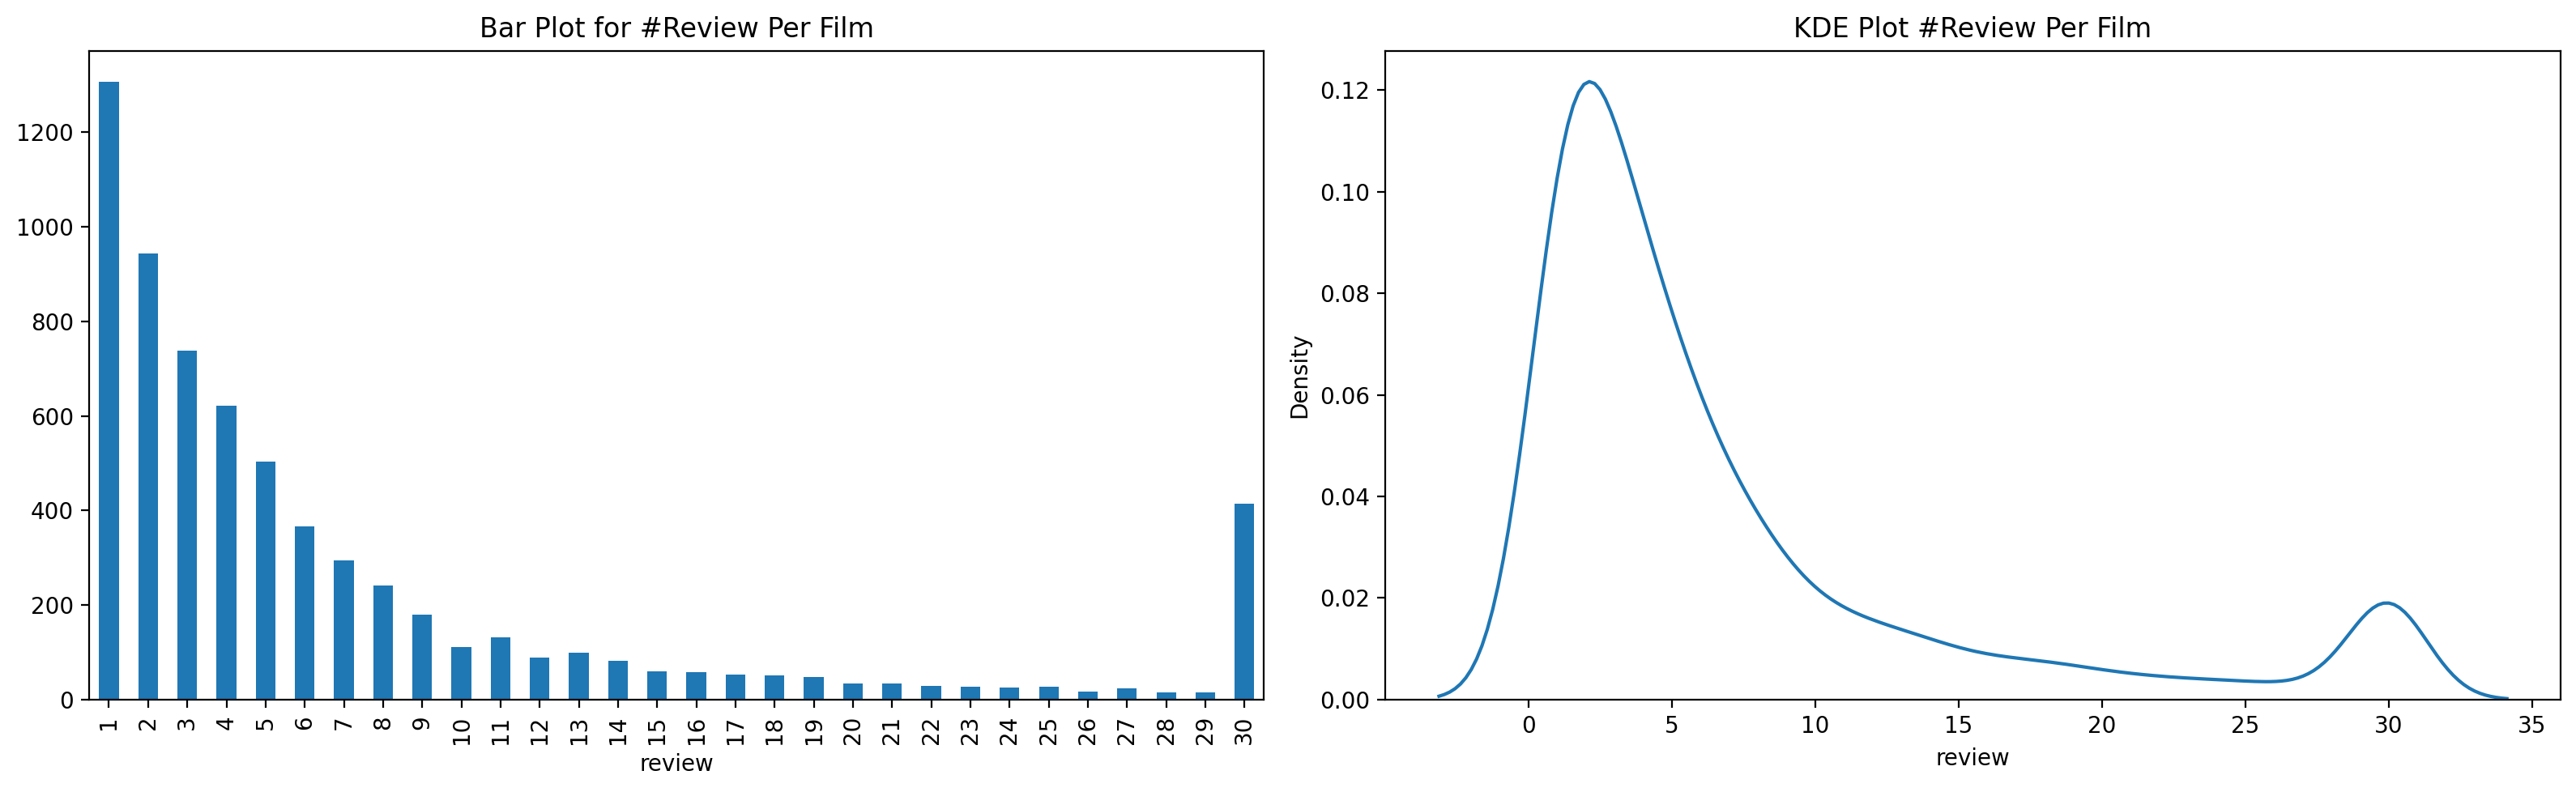

In [7]:
# Revisar la distribución del número de reseñas por película
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Bar Plot for #Review Per Film')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('KDE Plot #Review Per Film') 

fig.tight_layout()

La mayoría de las películas reciben un número limitado de reseñas, con menos de 5 reseñas. Sin embargo, también hay un número considerable de películas que tienen reseñas que llegan hasta 30.

A continuación, evaluaremos el equilibrio de clases en la columna `pos` para comparar la proporción de reseñas positivas y negativas en los datos. Como sabes, un valor de '0' representa reseñas negativas, mientras que '1' representa reseñas positivas.

In [8]:
# Contar el número de valores únicos
value_counts = df_reviews['pos'].value_counts()

# Calcular la proporción de valores únicos
value_props = round(df_reviews['pos'].value_counts(normalize=True) * 100, 2).astype('str') + '%'

# Fusionar los resultados en un DataFrame
df_pos = pd.DataFrame({'total': value_counts, 'percentage': value_props})

# Mostrar el DataFrame
df_pos

,total,percentage
pos,,
0,23715,50.11%
1,23614,49.89%


En general, el conjunto de datos está dividido de manera uniforme entre reseñas positivas y negativas, con un número ligeramente mayor de reseñas negativas. A continuación, analizaremos el equilibrio en la distribución de calificaciones en los conjuntos de datos de entrenamiento y prueba, como se identifica en la columna `ds_part`.

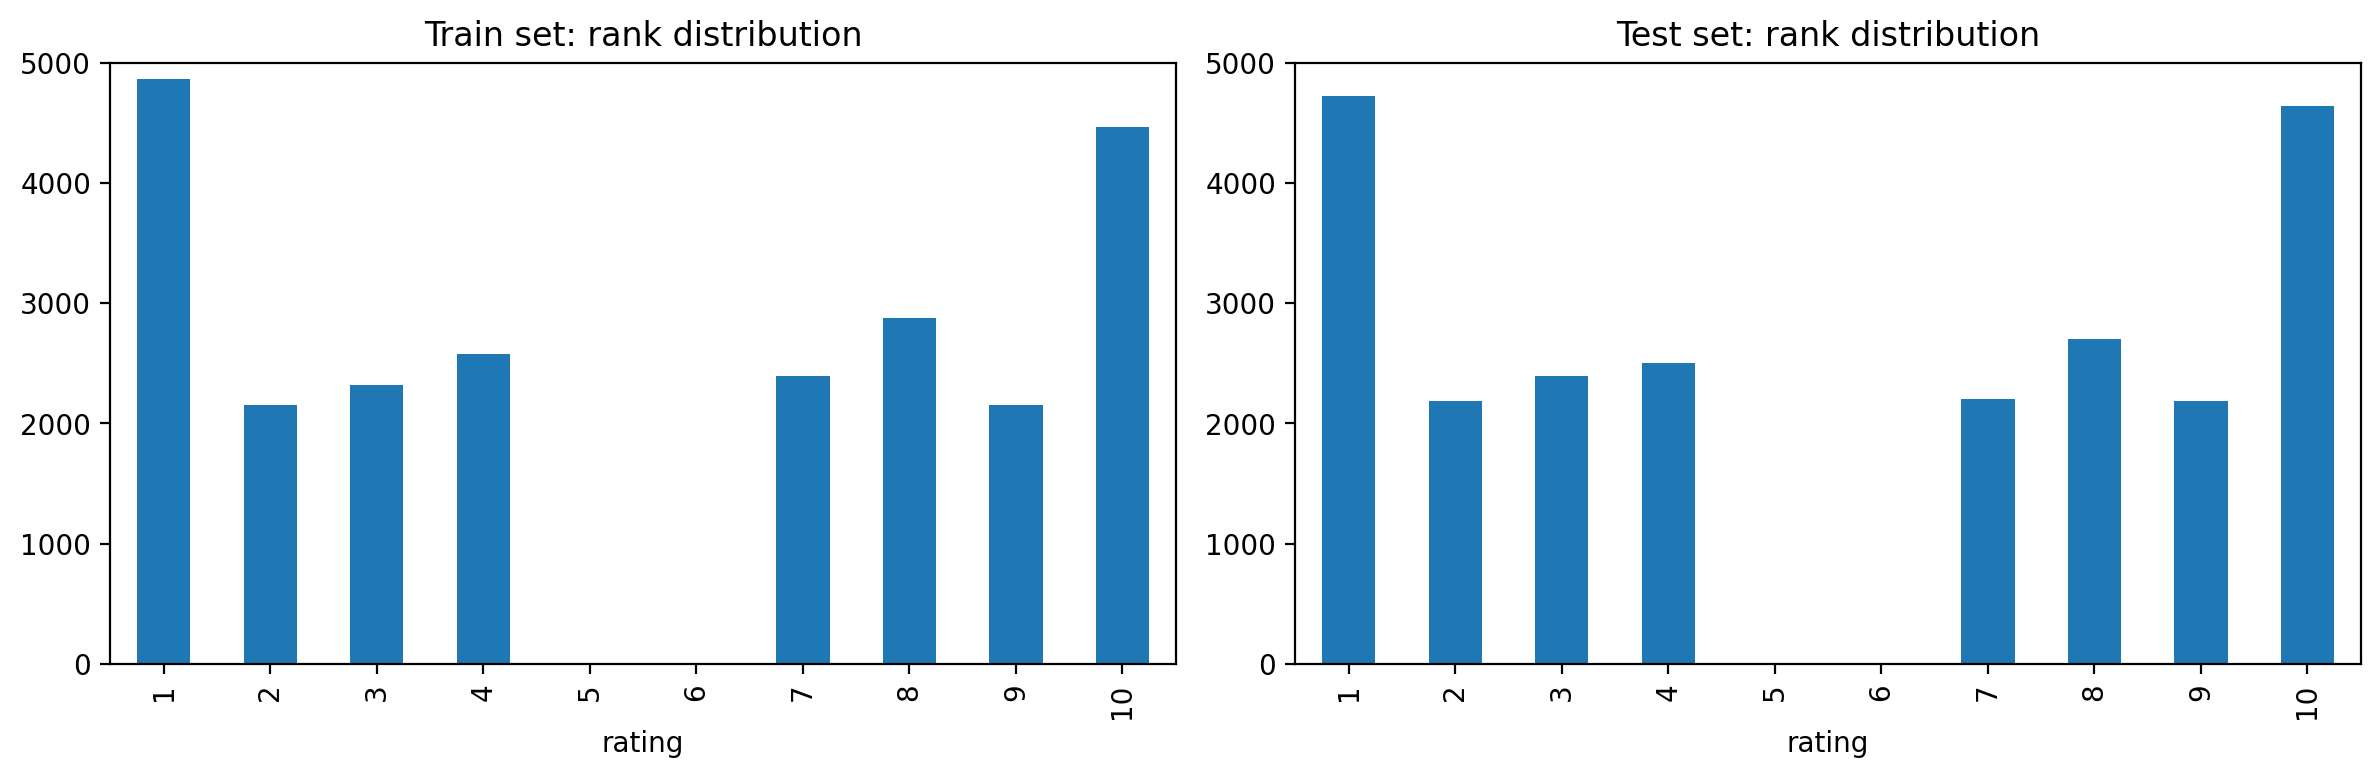

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('Train set: rank distribution')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('Test set: rank distribution')

fig.tight_layout()

La distribución de calificaciones entre el conjunto de entrenamiento y el conjunto de prueba es bastante similar. A continuación, investigaremos la distribución de reseñas negativas y positivas a lo largo de los años para ambas partes del conjunto de datos.

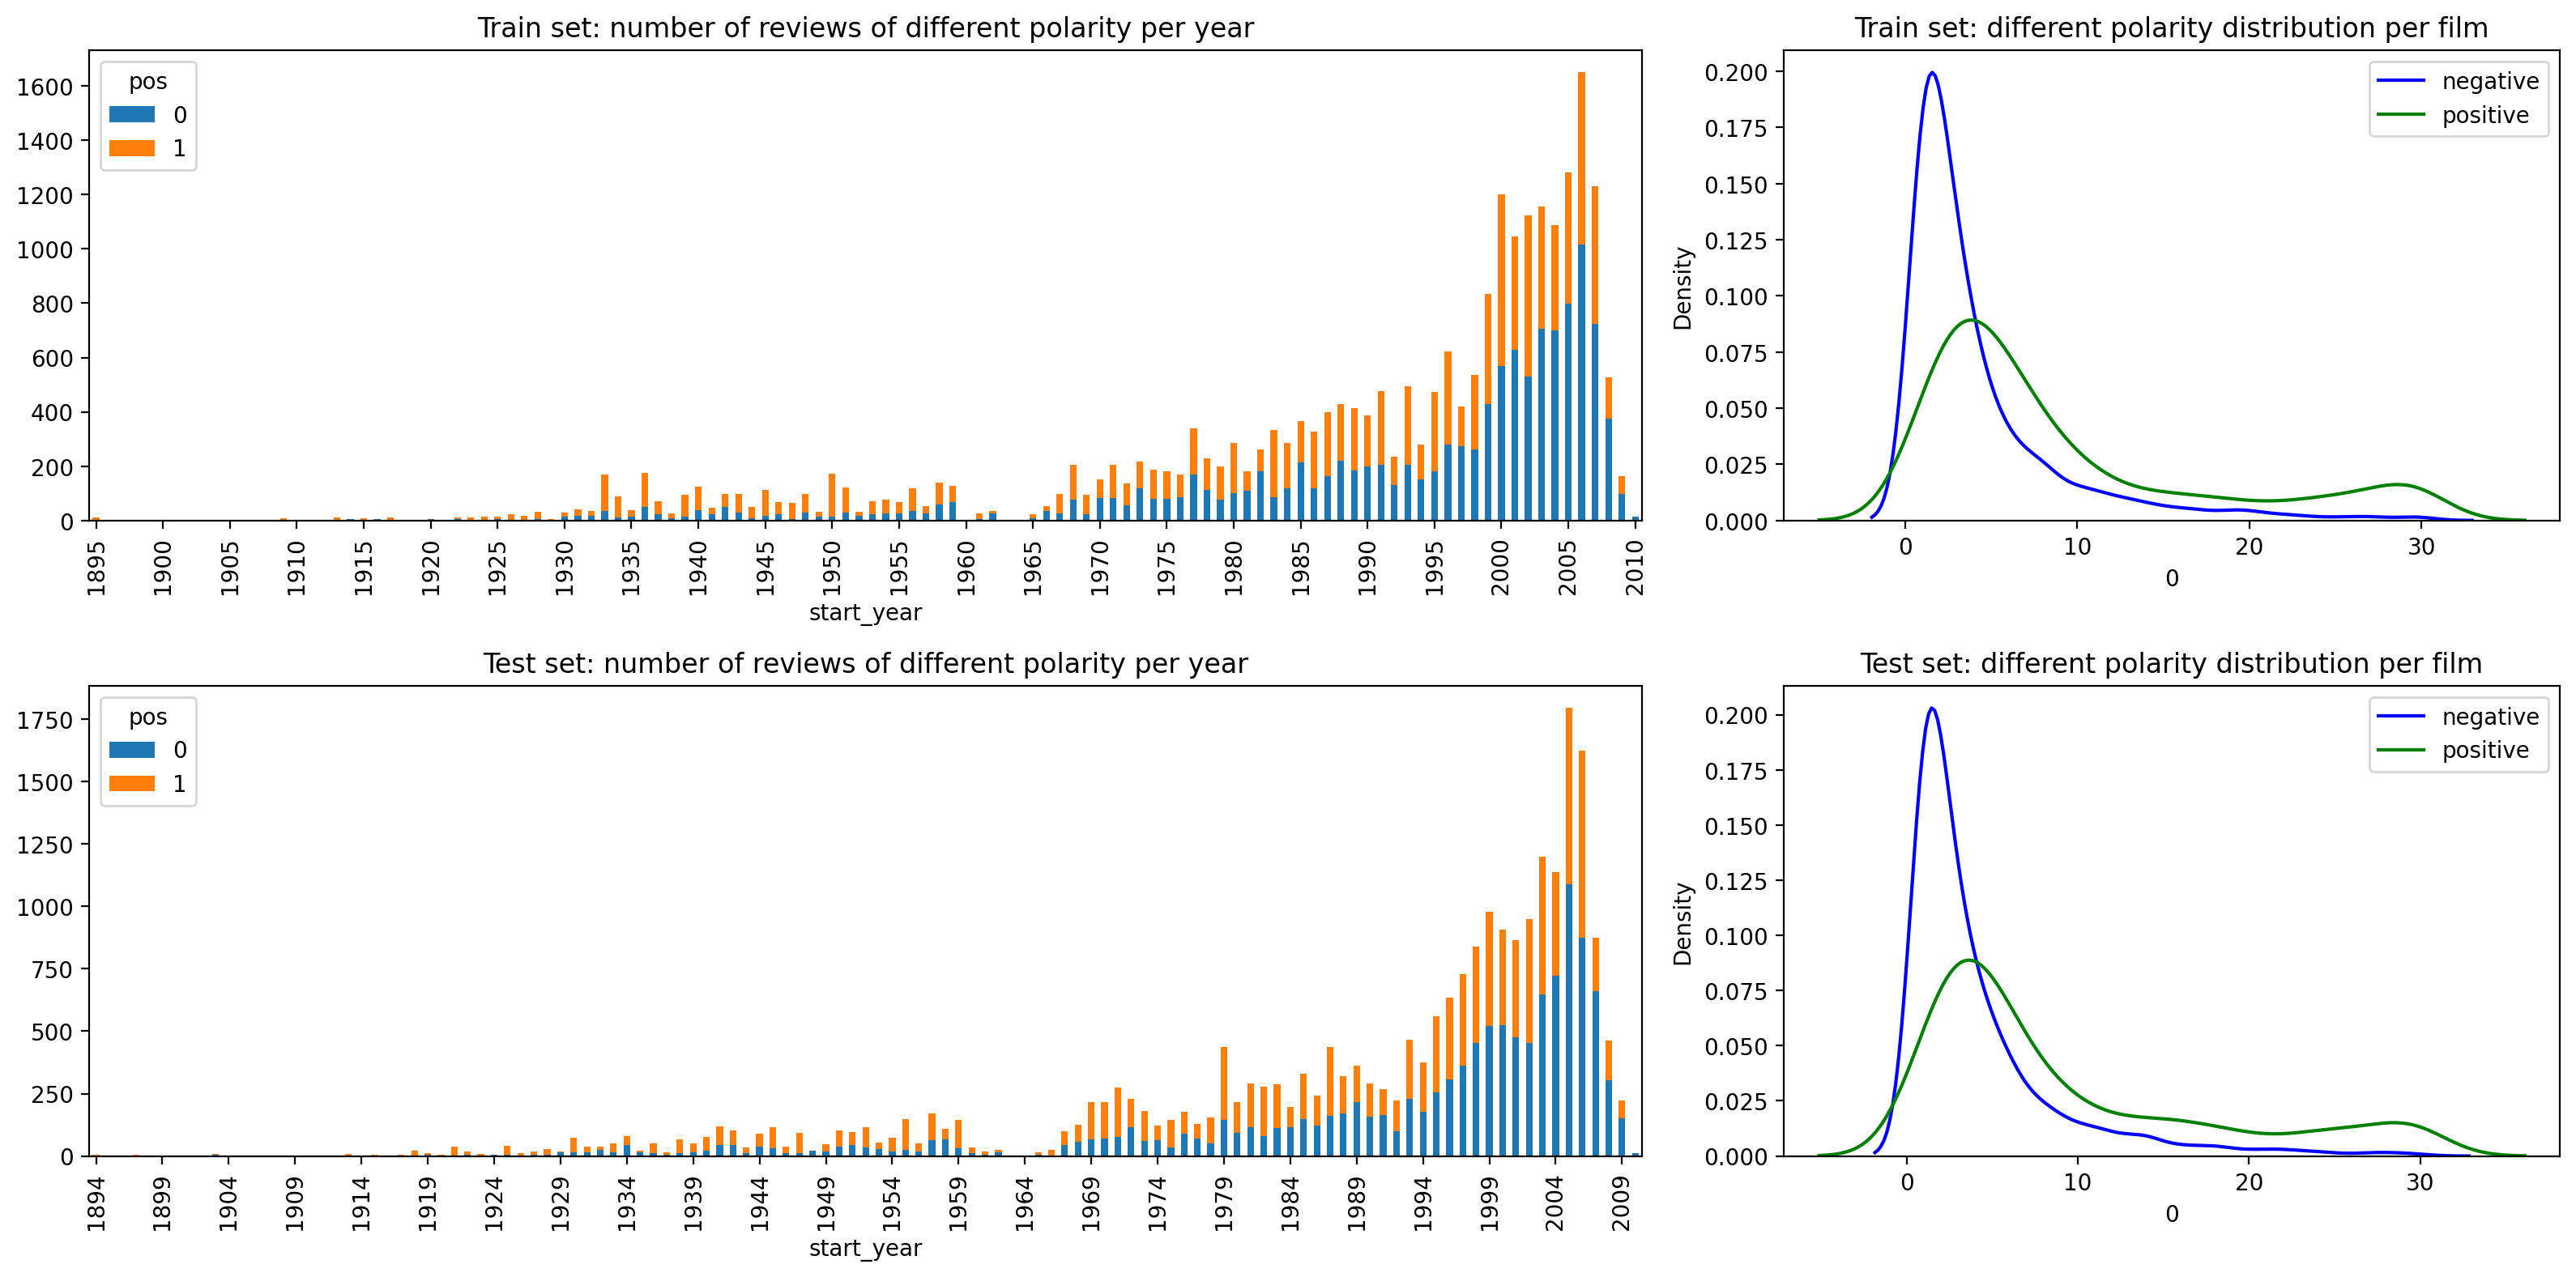

In [10]:
# Distribución de reseñas negativas y positivas por año para las dos partes del conjunto de datos
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2011))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('Train set: number of reviews of different polarity per year')
ax.set_xticks(range(0, len(dft.index), 5))
ax.set_xticklabels(dft.index[::5])

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('Train set: different polarity distribution per film')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2011))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('Test set: number of reviews of different polarity per year')
ax.set_xticks(range(0, len(dft.index), 5))
ax.set_xticklabels(dft.index[::5])

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('Test set: different polarity distribution per film')

fig.tight_layout()


La distribución de calificaciones en ambos conjuntos de datos es bastante similar. Para la mayoría de las películas con reseñas limitadas, las calificaciones negativas tienden a dominar. Sin embargo, para las películas con un mayor número de reseñas, las calificaciones positivas se vuelven más predominantes.

## 4 Procedimiento de Evaluación

Realizar evaluaciones regulares para todos los modelos en esta tarea para generar información útil y evaluar su rendimiento de manera efectiva.

In [11]:
# Definir la función de evaluación
def evaluate_model(model, features_train, target_train, features_test, target_test):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', features_train, target_train), ('test', features_test, target_test)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # Scor F1 
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, 
                color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # establece umbrales cruzados para múltiples niveles
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], 
                    color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'Skor F1') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # establece umbrales cruzados para múltiples niveles
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'Kurva ROC')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # establece umbrales cruzados para múltiples niveles
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], 
                    color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    
    return df_eval_stats
    

## 5 Normalización

Asumimos que todos los modelos a continuación están diseñados para manejar texto en minúsculas y sin números, puntuación ni otros caracteres especiales.

In [12]:
# Convertir todas las reseñas a minúsculas
df_reviews['review_norm'] = df_reviews['review'].str.lower()

# Eliminar números, puntuación y caracteres distintos a letras y espacios
df_reviews['review_norm'] = df_reviews['review_norm'].apply(lambda x: re.sub(r'[^a-z\s]', '', x))

In [13]:
# Verificar y comprobar los resultados
df_reviews[['review','review_norm']] 

,review,review_norm
0,The pakage implies that Warren Beatty and Gold...,the pakage implies that warren beatty and gold...
1,How the hell did they get this made?! Presenti...,how the hell did they get this made presenting...
2,There is no real story the film seems more lik...,there is no real story the film seems more lik...
3,Um .... a serious film about troubled teens in...,um a serious film about troubled teens in sin...
4,I'm totally agree with GarryJohal from Singapo...,im totally agree with garryjohal from singapor...
...,...,...
47326,This is another of my favorite Columbos. It sp...,this is another of my favorite columbos it spo...
47327,Talk about being boring! I got this expecting ...,talk about being boring i got this expecting a...
47328,"I never thought I'd say this about a biopic, b...",i never thought id say this about a biopic but...
47329,Spirit and Chaos is an artistic biopic of Miya...,spirit and chaos is an artistic biopic of miya...


Todas las reseñas han sido convertidas exitosamente a minúsculas y contienen solo letras y espacios, habiendo sido eliminados cualquier otro carácter.

## 6 División de Entrenamiento (Train) y Prueba (Test)

Todos los conjuntos de datos han sido etiquetados para propósitos de entrenamiento y prueba. La información sobre la división del conjunto de datos está indicada en la columna `ds_part`. Ahora dividiremos este conjunto de datos en dos grupos, es decir, entrenamiento y prueba, basándonos en las etiquetas de la columna `ds_part`.

In [14]:
# Crear dos nuevos conjuntos de datos para entrenamiento y prueba
df_reviews_train = df_reviews.query('ds_part == "train"')
df_reviews_test = df_reviews.query('ds_part == "test"')

features_train = df_reviews_train.drop('pos', axis=1)
target_train = df_reviews_train['pos']

features_test = df_reviews_test.drop('pos', axis=1)
target_test = df_reviews_test['pos']

print(features_train.shape)
print(features_test.shape)

(23796, 17)
(23533, 17)


## 7 Trabaja con Modelos

Ahora es el momento de entrenar un modelo de aprendizaje automático para análisis de sentimientos en el conjunto de datos existente. Utilizaremos varios modelos de entrenamiento de aprendizaje automático para comparar sus puntuaciones de precisión e identificar el modelo con mejor rendimiento.

Para establecer una referencia, utilizaremos el modelo constante, donde el modelo predice un solo valor, específicamente 1. Un modelo más sofisticado debería superar el rendimiento del modelo base.

### 7.1 Modelo 0 - Constante

,train,test
Accuracy,0.50,0.50
F1,0.67,0.67
APS,0.50,0.50
ROC AUC,0.50,0.50


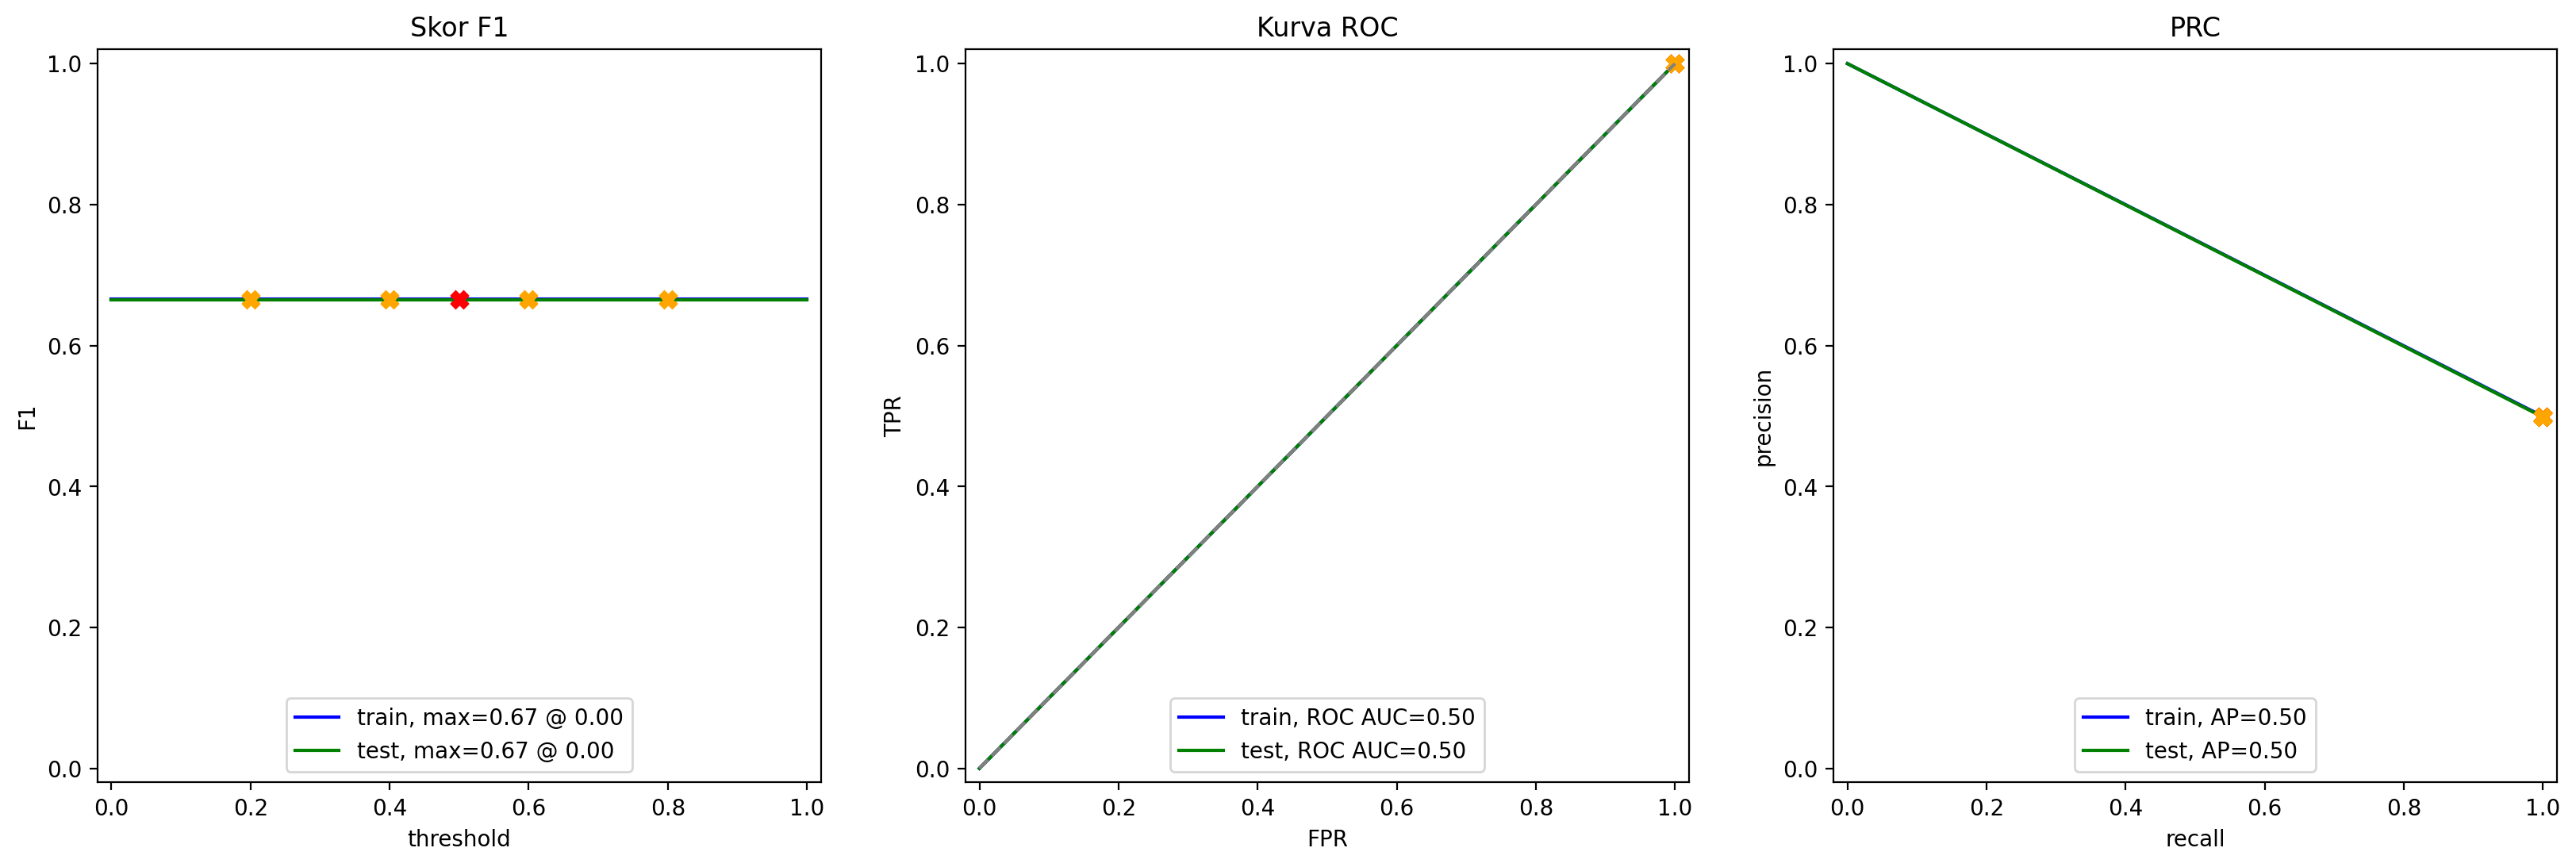

In [15]:
# Implementar el modelo 'DummyClassifier' con una estrategia 'constant'
model_0 = DummyClassifier(strategy='constant', constant=1).fit(features_train, target_train)

model_0_score = evaluate_model(model_0, features_train, target_train, features_test, target_test)
model_0_score

### 7.2 Modelo 1 - NLTK Logistic Regression

Probemos varios modelos utilizando el método TF-IDF (Frecuencia de Término - Frecuencia Inversa de Documento), que es una técnica común en el procesamiento de lenguaje natural para evaluar la importancia de las palabras en un documento.

Este método calcula la frecuencia de una palabra en un documento (TF) y cuán frecuentemente ocurre la palabra en los documentos de un conjunto de datos (IDF).

Para este modelo inicial, utilizaremos NLTK para apoyar el modelo de Regresión Logística.

#### 7.2.1 Implementando el Método TF-IDF con Preprocesamiento de NLTK

In [16]:
# Realizar el preprocesamiento de texto con NLTK
nltk.download('punkt')
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\USUARIO\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\USUARIO\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [17]:
# Tokeniza y lematiza los textos en la columna 'review_norm' para el entrenamiento
features_train_nltk = []
for text in features_train['review_norm']:
    tokens = word_tokenize(text)
    lemmas = [lemmatizer.lemmatize(token) for token in tokens]
    join = " ".join(lemmas)
    features_train_nltk.append(join)

In [18]:
# Tokeniza y lematiza los textos en la columna 'review_norm' para la prueba
features_test_nltk = []
for text in features_test['review_norm']:
    tokens = word_tokenize(text)
    lemmas = [lemmatizer.lemmatize(token) for token in tokens]
    join = " ".join(lemmas)
    features_test_nltk.append(join)

In [19]:
# Aplicar el método TF-IDF y eliminando palabras vacías
nltk.download('stopwords')
tf_idf = TfidfVectorizer(stop_words='english')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\USUARIO\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### 7.2.2 Crear Modelo 1

In [20]:
# Crear nuevas características implementando TF-IDF
features_train_1 = tf_idf.fit_transform(features_train_nltk)
features_test_1 = tf_idf.transform(features_test_nltk)

In [21]:
# Crear un modelo de Regresión Logística sin ajustar los hiperparámetros
model_1 = LogisticRegression().fit(features_train_1, target_train)

,train,test
Accuracy,0.94,0.88
F1,0.94,0.87
APS,0.98,0.95
ROC AUC,0.98,0.95


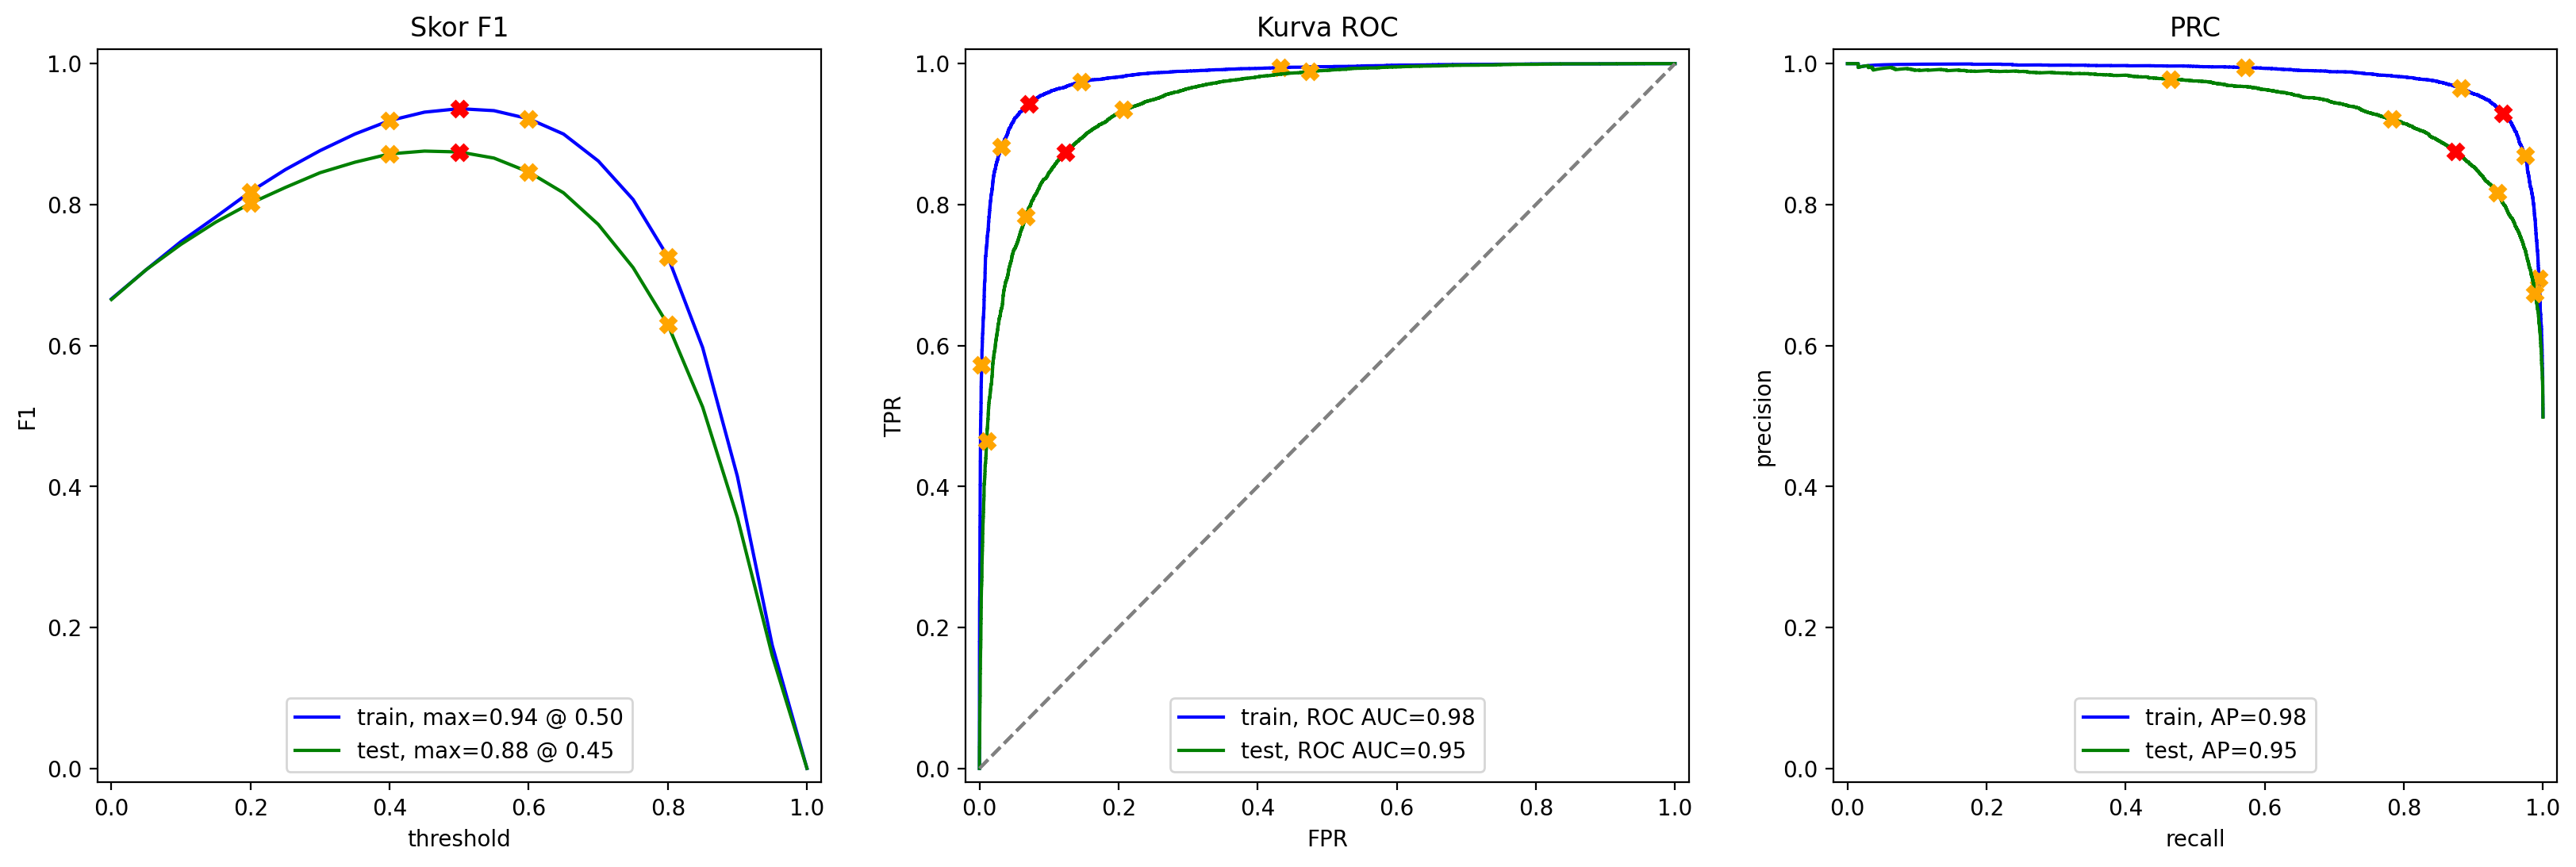

In [22]:
# Realizar la evaluación del modelo
model_1_score = evaluate_model(model_1, features_train_1, target_train, features_test_1, target_test)
model_1_score

Este modelo ofrece una puntuación bastante buena, mucho más alta que la del modelo base.

#### 7.2.3 Probar el Modelo 1 en Nuevos Datos de Prueba

Ahora, probaremos el modelo que se ha desarrollado en un nuevo conjunto de datos que contiene nuevas reseñas. Presentaremos 10 reseñas aleatorias, divididas equitativamente entre positivas y negativas. El modelo proporcionará puntuaciones de probabilidad para estas reseñas.

Una puntuación de probabilidad más cercana a 1 indica que la reseña es positiva, mientras que una puntuación más cercana a 0 indica que la reseña es negativa.

Este enfoque de evaluación se aplicará también a futuros modelos.

In [23]:
# Crear un nuevo DataFrame para prueba que contenga 10 líneas de reseñas de películas
# Las reseñas positivas y negativas se alternan, siendo la primera reseña negativa

my_reviews = pd.DataFrame([
    "This movie was an absolute waste of time. I wouldn't recommend it to anyone.",
    "I was thoroughly impressed with this film. The storyline was engaging and the acting was superb.",
    "I found this movie to be incredibly boring. It just didn't hold my attention.",
    "The special effects in this movie were out of this world. Definitely worth watching.",
    "I was disappointed by this film. It didn't live up to the hype.",
    "This movie was a masterpiece. I was blown away by the stunning visuals and emotional storyline.",
    "I thought the acting in this movie was terrible. It was hard to watch.",
    "I couldn't take my eyes off the screen. This movie had me on the edge of my seat from start to finish.",
    "The dialogue in this movie was so cheesy. I couldn't take it seriously.",
    "I loved this film. It had all the right elements to make a great movie.",
], columns=['review'])

my_reviews['review_norm'] = my_reviews['review'].str.lower().apply(lambda x: re.sub(r'[^a-z\s]', '', x))

my_reviews

,review,review_norm
0,This movie was an absolute waste of time. I wo...,this movie was an absolute waste of time i wou...
1,I was thoroughly impressed with this film. The...,i was thoroughly impressed with this film the ...
2,I found this movie to be incredibly boring. It...,i found this movie to be incredibly boring it ...
3,The special effects in this movie were out of ...,the special effects in this movie were out of ...
4,I was disappointed by this film. It didn't liv...,i was disappointed by this film it didnt live ...
5,This movie was a masterpiece. I was blown away...,this movie was a masterpiece i was blown away ...
6,I thought the acting in this movie was terribl...,i thought the acting in this movie was terribl...
7,I couldn't take my eyes off the screen. This m...,i couldnt take my eyes off the screen this mov...
8,The dialogue in this movie was so cheesy. I co...,the dialogue in this movie was so cheesy i cou...
9,I loved this film. It had all the right elemen...,i loved this film it had all the right element...


In [24]:
# Calcular la puntuación de probabilidad basada en el modelo
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_1.predict_proba(tf_idf.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.05:  this movie was an absolute waste of time i wouldnt recommend it to anyone
0.84:  i was thoroughly impressed with this film the storyline was engaging and the acting was superb
0.05:  i found this movie to be incredibly boring it just didnt hold my attention
0.97:  the special effects in this movie were out of this world definitely worth watching
0.17:  i was disappointed by this film it didnt live up to the hype
0.86:  this movie was a masterpiece i was blown away by the stunning visuals and emotional storyline
0.08:  i thought the acting in this movie was terrible it was hard to watch
0.71:  i couldnt take my eyes off the screen this movie had me on the edge of my seat from start to finish
0.15:  the dialogue in this movie was so cheesy i couldnt take it seriously
1.00:  i loved this film it had all the right elements to make a great movie


Este modelo muestra un contraste notable en los valores de probabilidad entre reseñas negativas y positivas. En la primera fila, que representa una reseña negativa, el valor de probabilidad está muy cerca de 0, mientras que en la segunda fila, que corresponde a una reseña positiva, la probabilidad está muy cerca de 1.

### 7.3 Modelo 2 - spaCy Logistic Regression

Seguiremos los mismos pasos que para el primer modelo, pero esta vez utilizaremos la biblioteca spaCy para el procesamiento de lenguaje natural (NLP).

#### 7.3.1 Implementando el Método TF-IDF con Preprocesamiento de spaCy

In [25]:
# Realizar el preprocesamiento de texto utilizando spaCy
# Hacer que los modelos en inglés se conviertan en variables 'nlp'
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Utilizamos un enfoque alternativo esta vez
# En lugar de usar bucles, definimos una función para lematizar y eliminar palabras vacías
def text_preprocessing(text):
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if not token.is_stop]
        
    return ' '.join(tokens)

In [26]:
# Crear una nueva característica implementando la función definida anteriormente
features_train_spacy = features_train['review_norm'].apply(lambda x: text_preprocessing(x))
features_test_spacy = features_test['review_norm'].apply(lambda x: text_preprocessing(x))

In [27]:
# Implementar el método TF-IDF
tf_idf_2 = TfidfVectorizer()
features_train_2 = tf_idf_2.fit_transform(features_train_spacy)
features_test_2 = tf_idf_2.transform(features_test_spacy)

#### 7.3.2 Crear Modelo 2

In [28]:
# Crear un modelo de Regresión Logística sin ajustar los hiperparámetros
model_2 = LogisticRegression().fit(features_train_2, target_train)

,train,test
Accuracy,0.93,0.87
F1,0.93,0.87
APS,0.98,0.94
ROC AUC,0.98,0.95


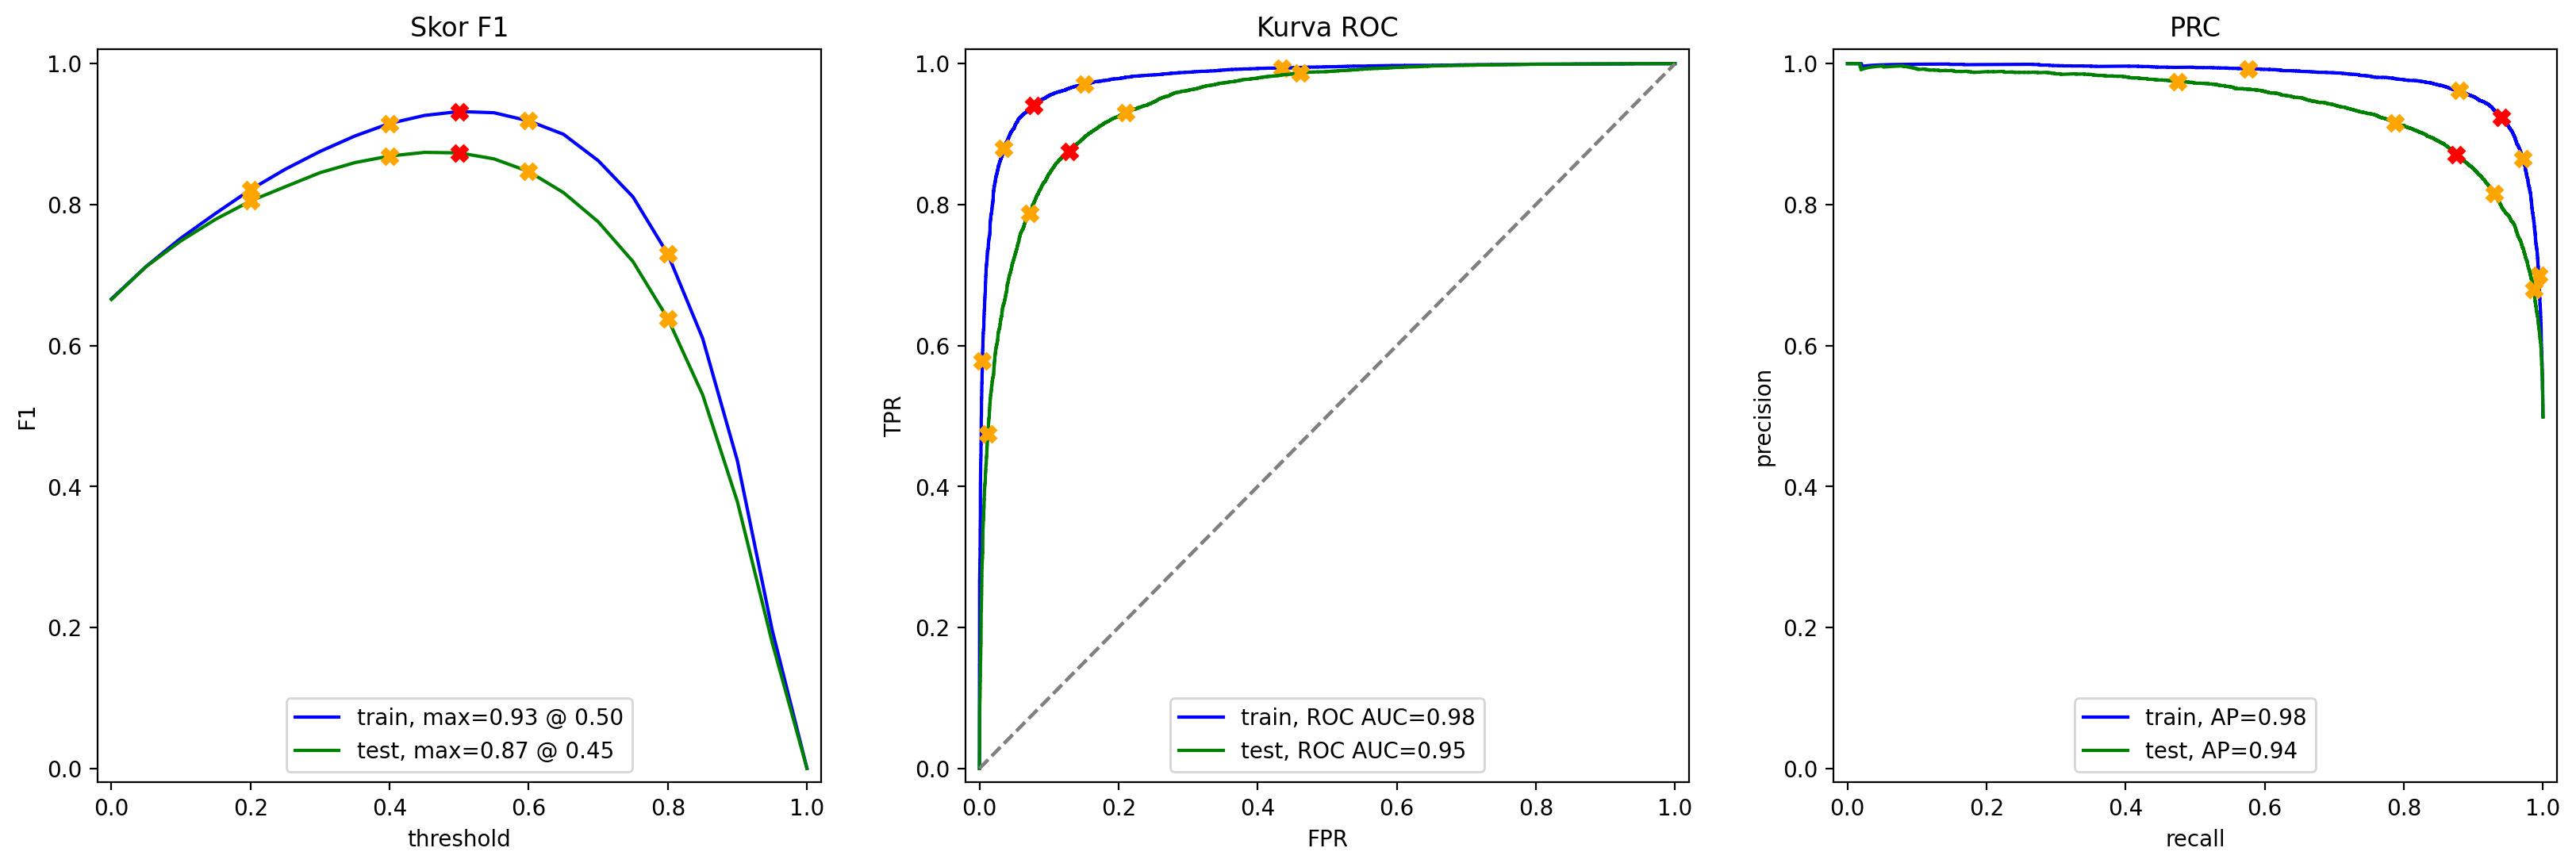

In [29]:
# Realizar la evaluación del modelo
model_2_score = evaluate_model(model_2, features_train_2, target_train, features_test_2, target_test)
model_2_score

En general, la puntuación no es significativamente mejor que la del modelo anterior.

#### 7.3.3 Probando el Modelo 2 en Nuevos Datos de Prueba

In [30]:
# Calcular la puntuación de probabilidad basada en el modelo
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_2.predict_proba(tf_idf_2.transform(texts.apply(lambda x: text_preprocessing(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.05:  this movie was an absolute waste of time i wouldnt recommend it to anyone
0.78:  i was thoroughly impressed with this film the storyline was engaging and the acting was superb
0.09:  i found this movie to be incredibly boring it just didnt hold my attention
0.96:  the special effects in this movie were out of this world definitely worth watching
0.22:  i was disappointed by this film it didnt live up to the hype
0.86:  this movie was a masterpiece i was blown away by the stunning visuals and emotional storyline
0.03:  i thought the acting in this movie was terrible it was hard to watch
0.67:  i couldnt take my eyes off the screen this movie had me on the edge of my seat from start to finish
0.08:  the dialogue in this movie was so cheesy i couldnt take it seriously
1.00:  i loved this film it had all the right elements to make a great movie


Este modelo también funciona bien al hacer predicciones con diferencias claras en las probabilidades.

Al igual que el primer modelo, este segundo modelo predice con precisión la probabilidad positiva en la décima línea, que contiene la palabra 'loved'.

### 7.4 Modelo 3 - NLTK LGBMClassifier

Ahora, procederemos a probar el modelo de **gradient boosting**, LightGBM Classifier. Una vez más, utilizaremos el método TF-IDF con procesamiento de lenguaje natural (NLP) de la biblioteca NLTK.

#### 7.4.1 Crear Modelo 3

In [31]:
# Crear nuevas características, aplica el método TF-IDF y elimina palabras vacías
features_train_3 = tf_idf.fit_transform(features_train_nltk)
features_test_3 = tf_idf.transform(features_test_nltk)

In [32]:
# Crear un modelo de LightGBM Classifier sin ajustar los hiperparámetros
model_3 = LGBMClassifier().fit(features_train_3, target_train)

[LightGBM] [Info] Number of positive: 11884, number of negative: 11912
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.254245 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 455044
[LightGBM] [Info] Number of data points in the train set: 23796, number of used features: 10233
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499412 -> initscore=-0.002353
[LightGBM] [Info] Start training from score -0.002353


,train,test
Accuracy,0.91,0.86
F1,0.91,0.86
APS,0.97,0.93
ROC AUC,0.97,0.93


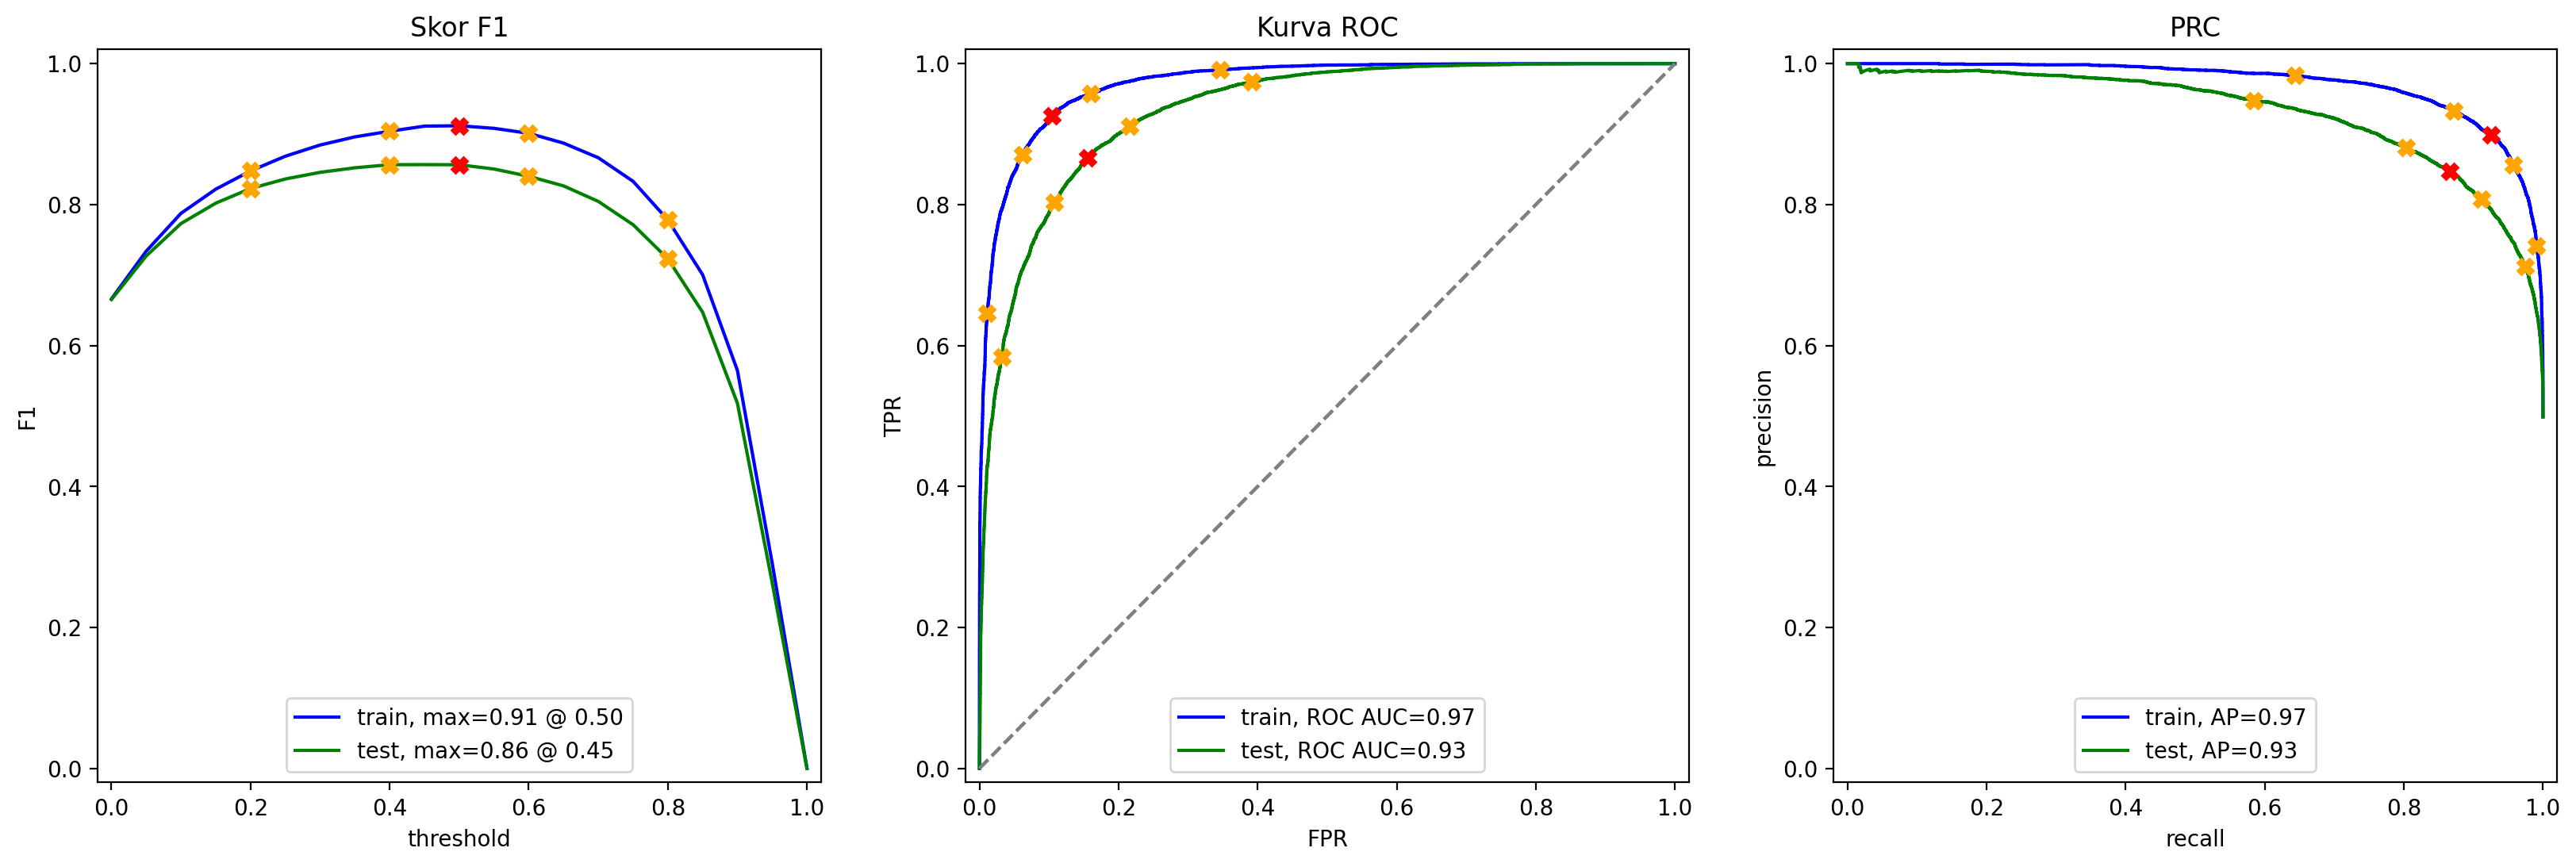

In [33]:
# Realizar la evaluación del modelo
model_3_score = evaluate_model(model_3, features_train_3, target_train, features_test_3, target_test)
model_3_score

No ofrece un rendimiento mejor que el Modelo 1 y el Modelo 2 en términos de puntuación.

#### 7.4.2 Probando el Modelo 3 en Nuevos Datos de Prueba

In [34]:
# Calcular la puntuación de probabilidad basada en el modelo
my_reviews_pred_prob = model_3.predict_proba(tf_idf.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.10:  this movie was an absolute waste of time i wouldnt recommend it to anyone
0.84:  i was thoroughly impressed with this film the storyline was engaging and the acting was superb
0.14:  i found this movie to be incredibly boring it just didnt hold my attention
0.88:  the special effects in this movie were out of this world definitely worth watching
0.55:  i was disappointed by this film it didnt live up to the hype
0.81:  this movie was a masterpiece i was blown away by the stunning visuals and emotional storyline
0.16:  i thought the acting in this movie was terrible it was hard to watch
0.71:  i couldnt take my eyes off the screen this movie had me on the edge of my seat from start to finish
0.61:  the dialogue in this movie was so cheesy i couldnt take it seriously
0.92:  i loved this film it had all the right elements to make a great movie


Aunque no es tan preciso como los dos modelos anteriores, todavía demuestra una buena capacidad para distinguir entre reseñas positivas y negativas.

Sin embargo, en la reseña de la quinta línea, el modelo clasifica incorrectamente la reseña negativa como positiva con una probabilidad del 55 por ciento. Lo mismo ocurre en la novena fila. Aunque esta diferencia de probabilidad es relativamente pequeña, si el umbral se establece en el 50 por ciento, entonces esta predicción sería incorrecta.

### 7.5 Modelo 4 - spaCy LGBMClassifier

Desarrollaremos nuevamente un modelo de LightGBM Classifier, pero esta vez utilizaremos los métodos TF-IDF y NLP de spaCy.

#### 7.5.1 Crear Modelo 4

In [35]:
# Crear nuevas características e implementa los métodos TF-IDF
features_train_4 = tf_idf_2.fit_transform(features_train_spacy)
features_test_4 = tf_idf_2.transform(features_test_spacy)

In [36]:
# Crear un modelo de LightGBM Classifier sin ajustar los hiperparámetros
model_4 = LGBMClassifier().fit(features_train_4, target_train)

[LightGBM] [Info] Number of positive: 11884, number of negative: 11912
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.196555 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 423377
[LightGBM] [Info] Number of data points in the train set: 23796, number of used features: 9245
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499412 -> initscore=-0.002353
[LightGBM] [Info] Start training from score -0.002353


,train,test
Accuracy,0.91,0.85
F1,0.91,0.85
APS,0.97,0.93
ROC AUC,0.97,0.93


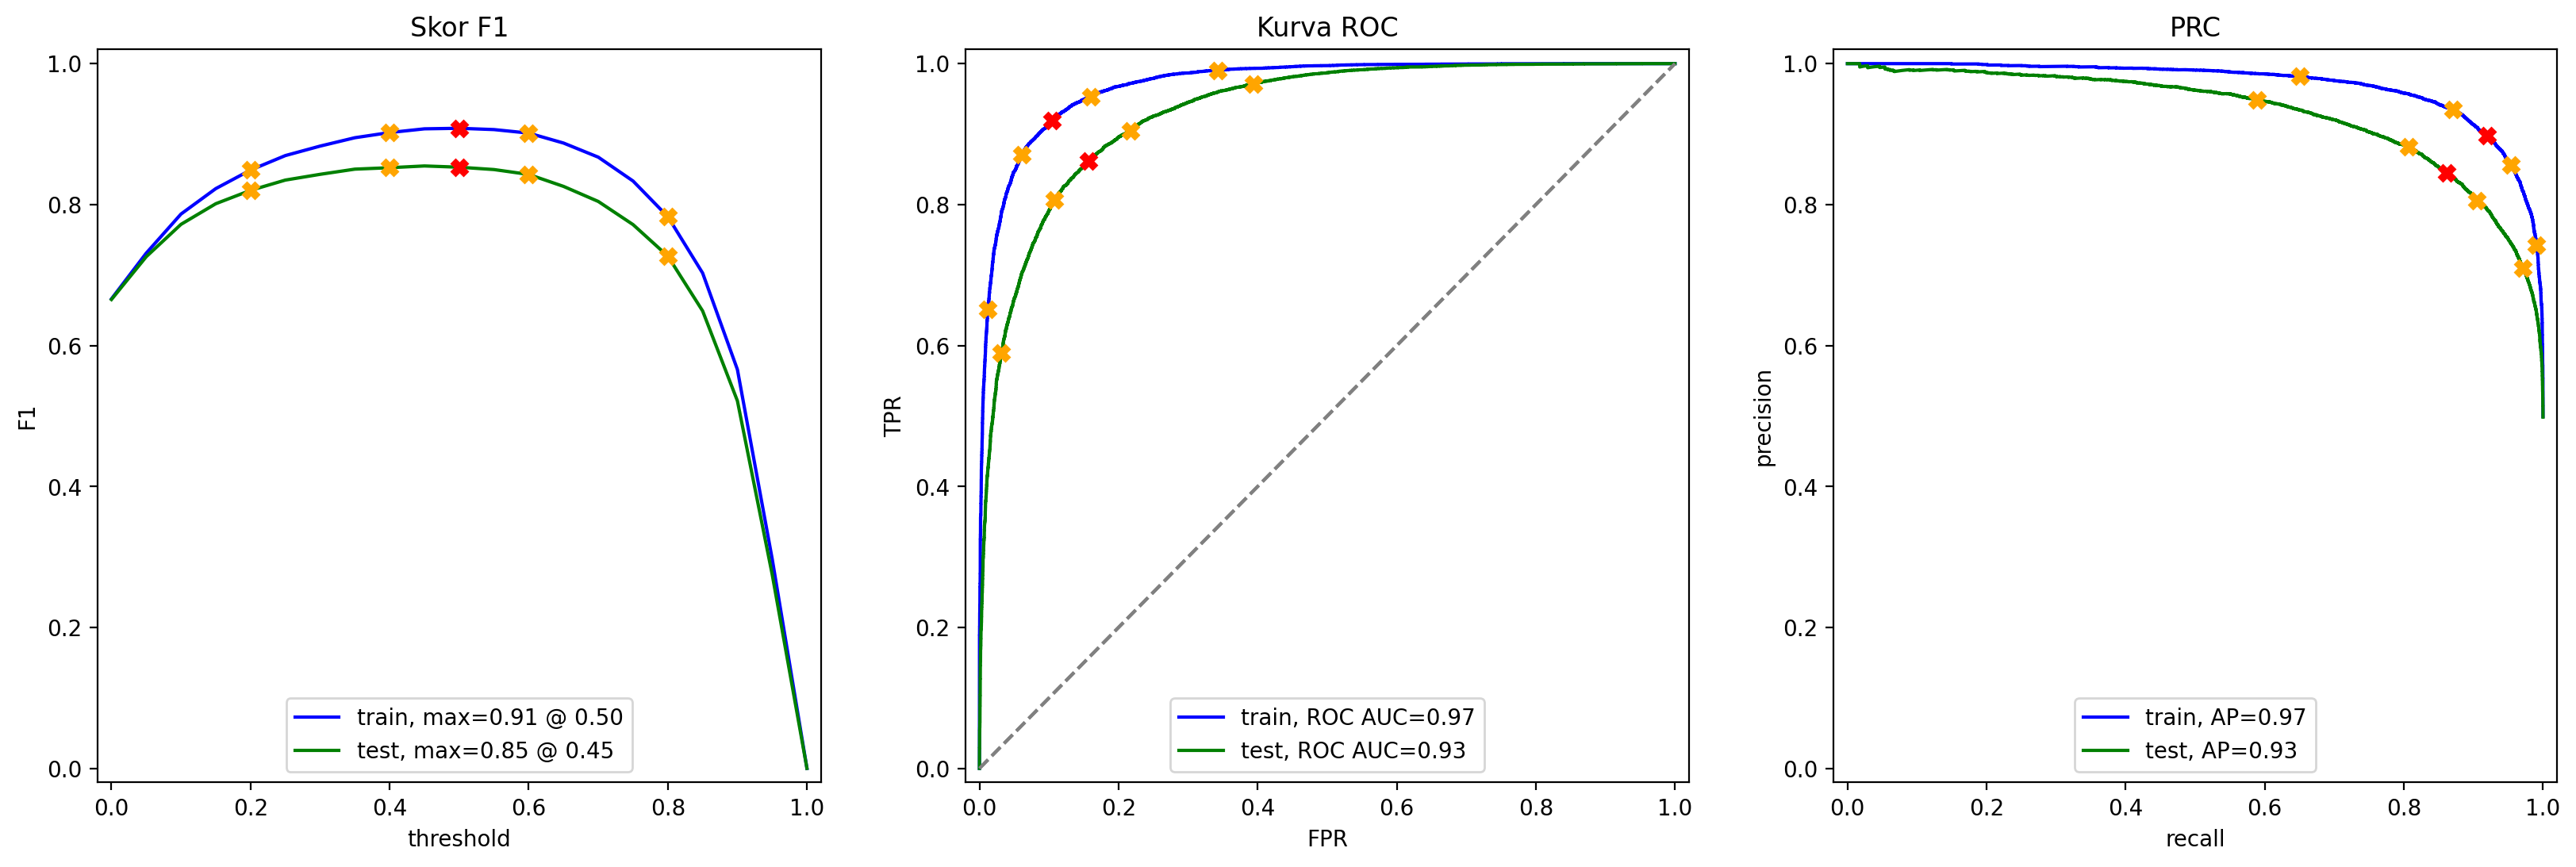

In [37]:
# Realizar la evaluación del modelo
model_4_score = evaluate_model(model_4, features_train_4, target_train, features_test_4, target_test)
model_4_score

La puntuación muestra una disminución.

#### 7.5.2 Probando el Modelo 4 en Nuevos Datos de Prueba

In [38]:
# Calcular la puntuación de probabilidad basada en el modelo
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_4.predict_proba(tf_idf_2.transform(texts.apply(lambda x: text_preprocessing(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.11:  this movie was an absolute waste of time i wouldnt recommend it to anyone
0.84:  i was thoroughly impressed with this film the storyline was engaging and the acting was superb
0.13:  i found this movie to be incredibly boring it just didnt hold my attention
0.87:  the special effects in this movie were out of this world definitely worth watching
0.42:  i was disappointed by this film it didnt live up to the hype
0.79:  this movie was a masterpiece i was blown away by the stunning visuals and emotional storyline
0.15:  i thought the acting in this movie was terrible it was hard to watch
0.49:  i couldnt take my eyes off the screen this movie had me on the edge of my seat from start to finish
0.41:  the dialogue in this movie was so cheesy i couldnt take it seriously
0.94:  i loved this film it had all the right elements to make a great movie


En general, este modelo también realiza buenas predicciones, aunque muestra un error en la octava línea.

### 7.6 Modelo 5 - NLTK XGBoost Classifier

Esta vez, implementaremos el siguiente modelo de **gradient boosting**, el XGBoost Classifier.

#### 7.6.1 Crear Modelo 5

In [39]:
# Crear nuevas características, aplica el método TF-IDF y elimina palabras vacías
features_train_5 = tf_idf.fit_transform(features_train_nltk)
features_test_5 = tf_idf.transform(features_test_nltk)

In [40]:
# Crear un modelo de XGBoost Classifier sin ajustar los hiperparámetros
model_5 = XGBClassifier().fit(features_train_5, target_train)

,train,test
Accuracy,0.94,0.85
F1,0.94,0.85
APS,0.99,0.92
ROC AUC,0.99,0.93


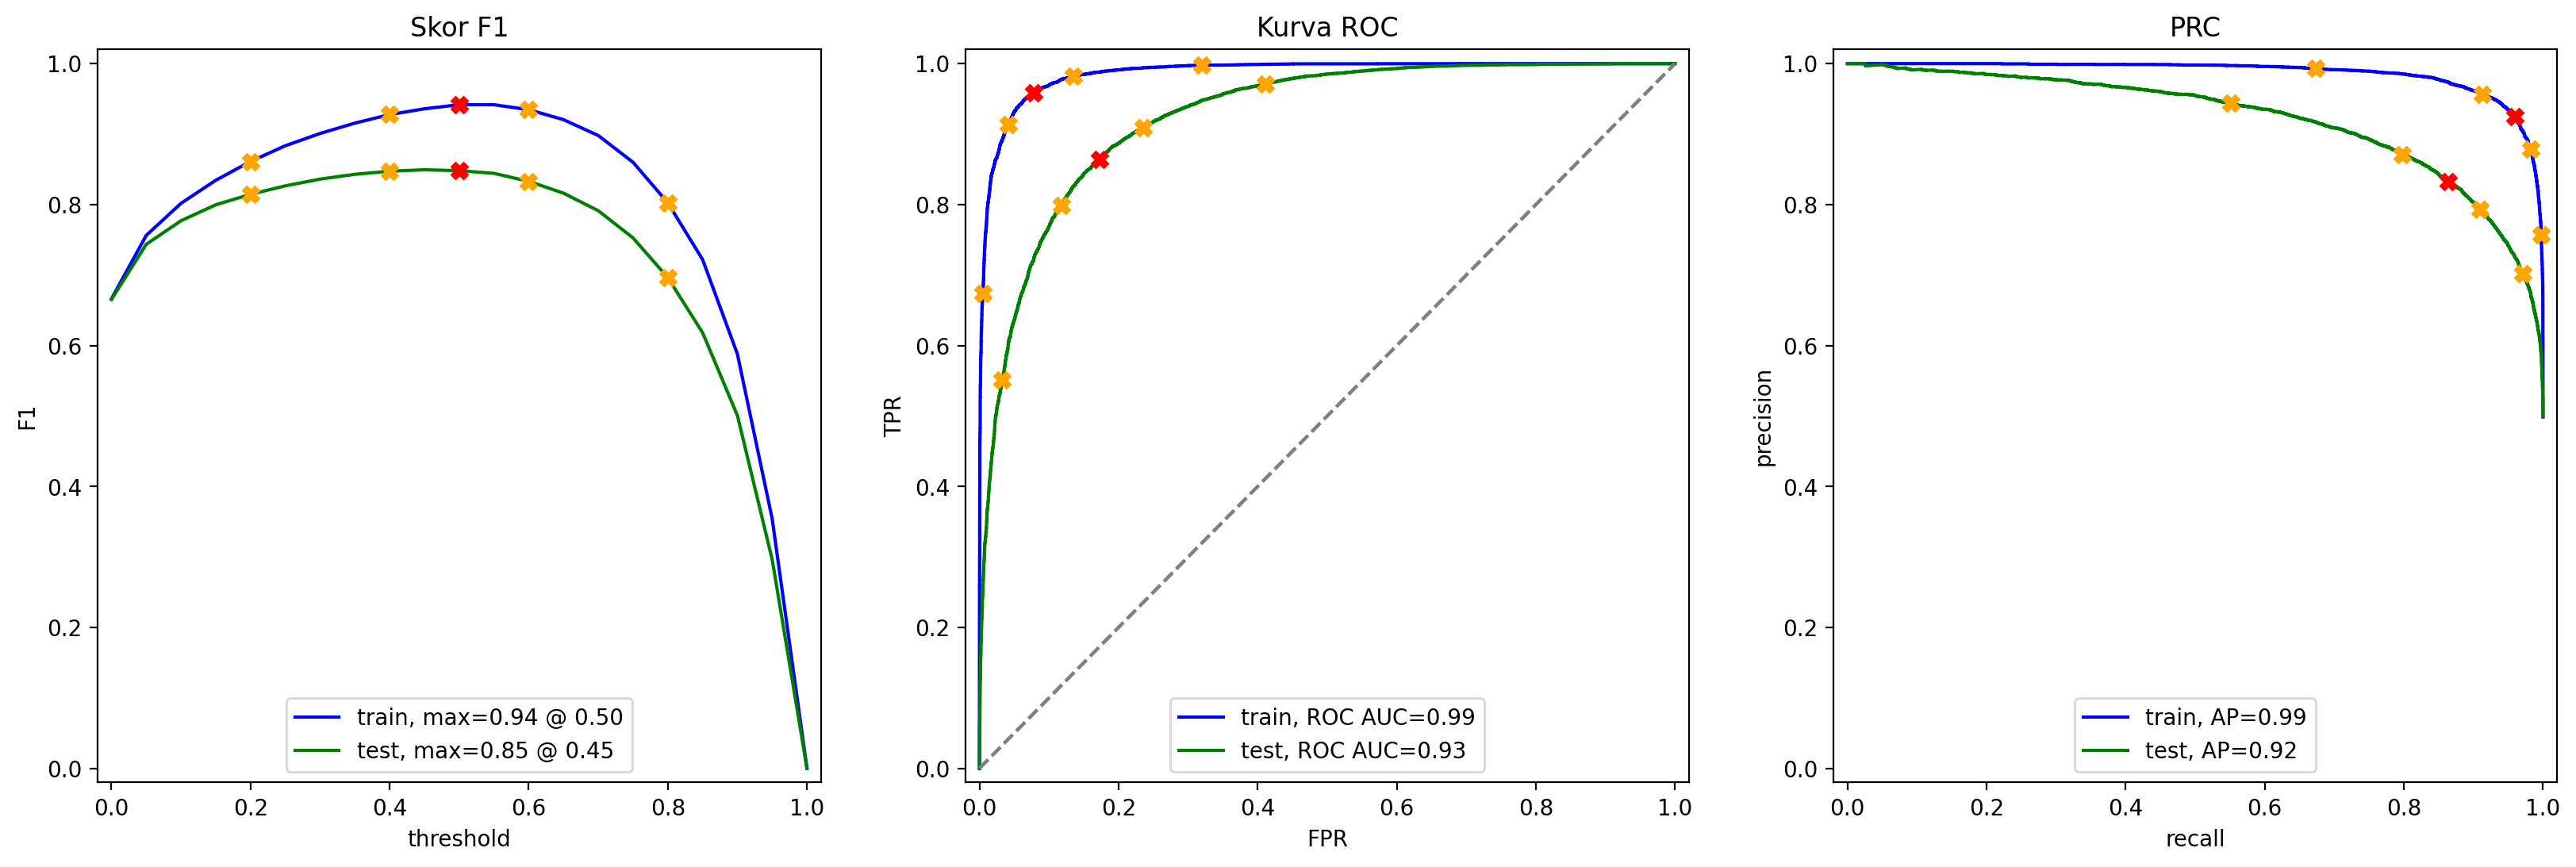

In [41]:
# Realizar la evaluación del modelo
model_5_score = evaluate_model(model_5, features_train_5, target_train, features_test_5, target_test)
model_5_score

Obtuvimos una puntuación mejor que la del Modelo 1 para el conjunto de entrenamiento, pero la puntuación para el conjunto de prueba sigue siendo ligeramente inferior a la del Modelo 1.

#### 7.6.2 Probando el Modelo 5 en Nuevos Datos de Prueba

In [42]:
# Calcular la puntuación de probabilidad basada en el modelo
my_reviews_pred_prob = model_5.predict_proba(tf_idf.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.09:  this movie was an absolute waste of time i wouldnt recommend it to anyone
0.74:  i was thoroughly impressed with this film the storyline was engaging and the acting was superb
0.21:  i found this movie to be incredibly boring it just didnt hold my attention
0.83:  the special effects in this movie were out of this world definitely worth watching
0.60:  i was disappointed by this film it didnt live up to the hype
0.66:  this movie was a masterpiece i was blown away by the stunning visuals and emotional storyline
0.28:  i thought the acting in this movie was terrible it was hard to watch
0.61:  i couldnt take my eyes off the screen this movie had me on the edge of my seat from start to finish
0.61:  the dialogue in this movie was so cheesy i couldnt take it seriously
0.90:  i loved this film it had all the right elements to make a great movie


En general, este modelo no tiene un buen desempeño en las predicciones. Los errores son evidentes en las filas 5 y 9. Además, la diferencia de probabilidad entre calificaciones positivas y negativas no es clara. La mayoría de los valores de probabilidad se encuentran en el medio, lo que indica que el modelo no puede predecir con certeza.

### 7.7 Modelo 6 - spaCy XGBoost Classifier

Usaremos el XGBoost Classifier nuevamente, pero esta vez con spaCy para el procesamiento de lenguaje natural (NLP).

#### 7.7.1 Crear Modelo 6

In [43]:
# Crear nuevas características e implementa los métodos TF-IDF
features_train_6 = tf_idf_2.fit_transform(features_train_spacy)
features_test_6 = tf_idf_2.transform(features_test_spacy)

In [44]:
# Crear un modelo de XGBoost Classifier sin ajustar los hiperparámetros
model_6 = XGBClassifier().fit(features_train_6, target_train)

,train,test
Accuracy,0.94,0.84
F1,0.94,0.85
APS,0.99,0.92
ROC AUC,0.99,0.92


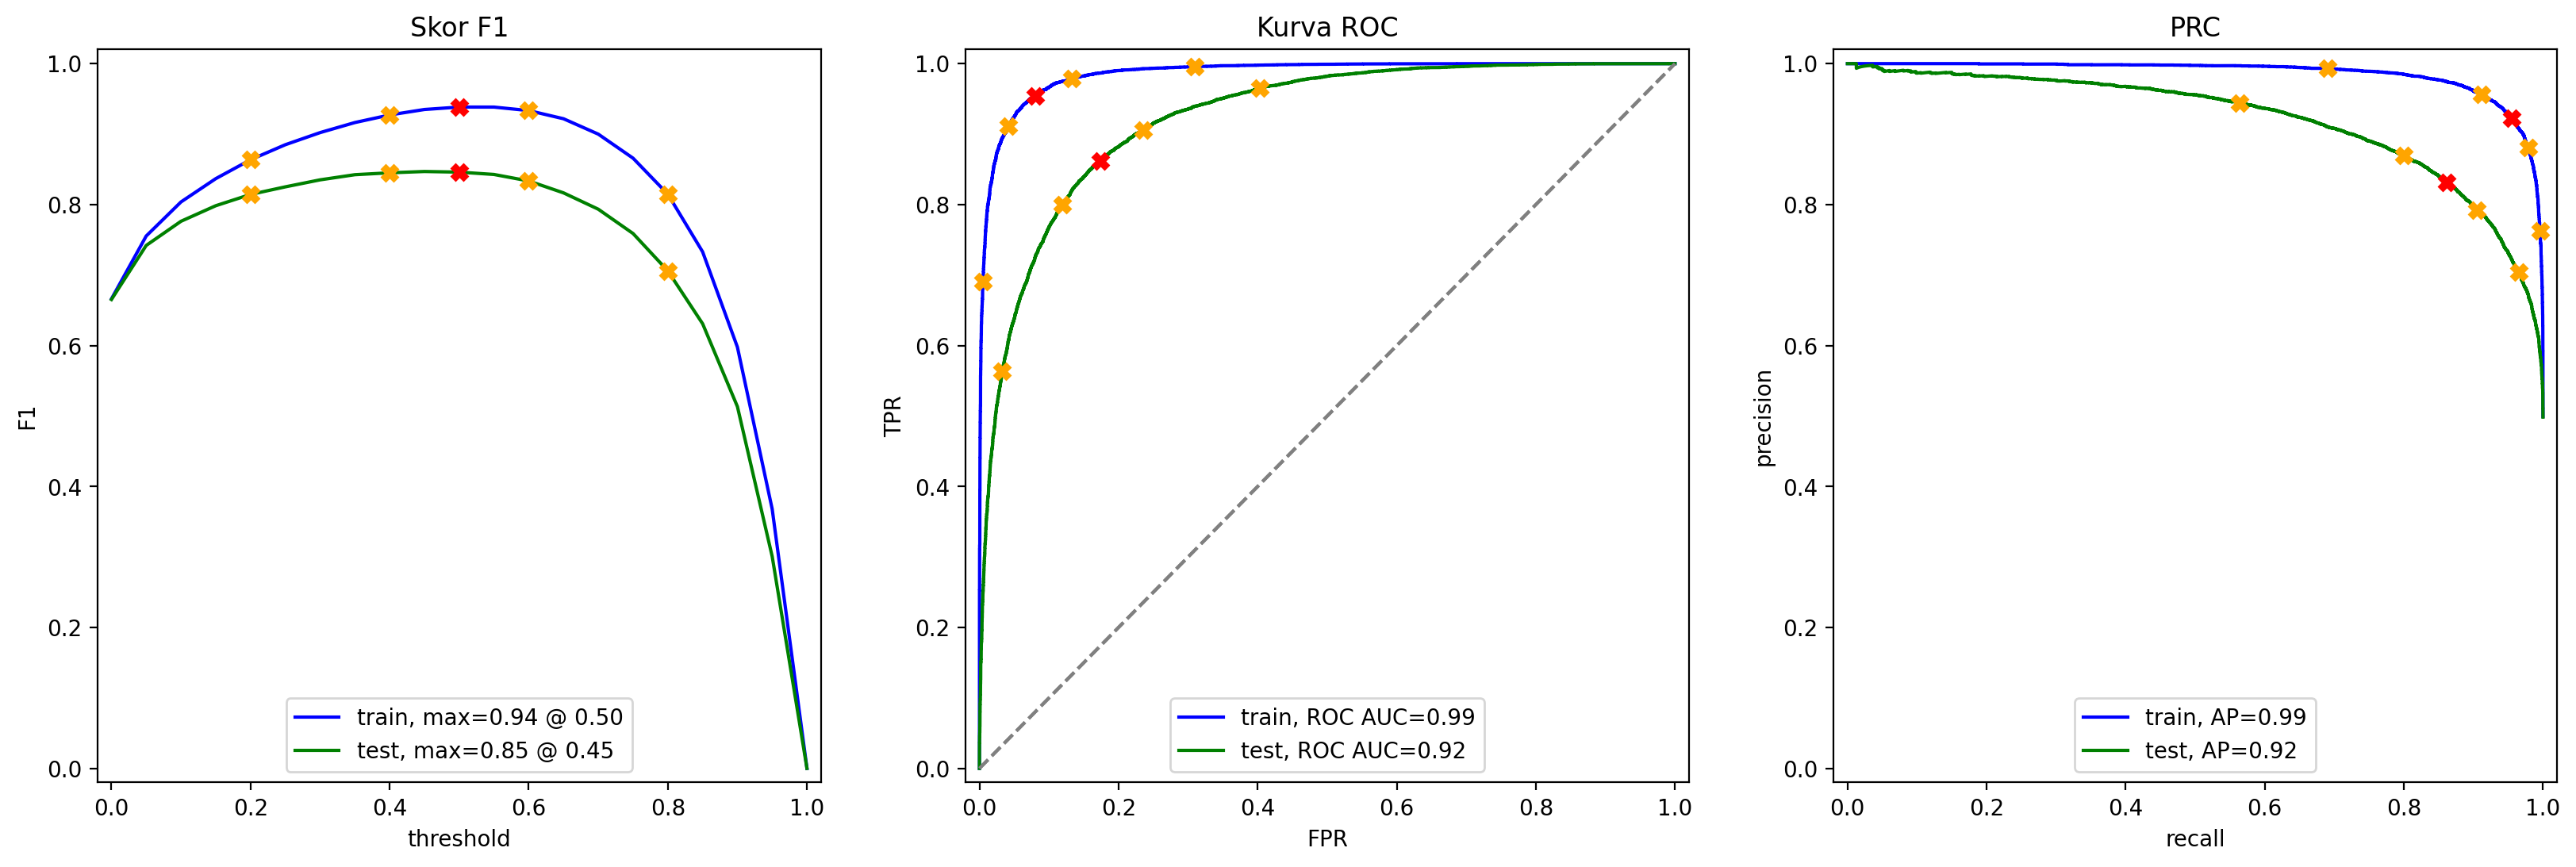

In [45]:
# Realizar la evaluación del modelo
model_6_score = evaluate_model(model_6, features_train_6, target_train, features_test_6, target_test)
model_6_score

Los resultados no son mejores que los del Modelo 5.

#### 7.7.2 Probando el Modelo 6 en Nuevos Datos de Prueba

In [46]:
# Calcular la puntuación de probabilidad basada en el modelo
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_6.predict_proba(tf_idf_2.transform(texts.apply(lambda x: text_preprocessing(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.08:  this movie was an absolute waste of time i wouldnt recommend it to anyone
0.81:  i was thoroughly impressed with this film the storyline was engaging and the acting was superb
0.17:  i found this movie to be incredibly boring it just didnt hold my attention
0.84:  the special effects in this movie were out of this world definitely worth watching
0.47:  i was disappointed by this film it didnt live up to the hype
0.69:  this movie was a masterpiece i was blown away by the stunning visuals and emotional storyline
0.21:  i thought the acting in this movie was terrible it was hard to watch
0.44:  i couldnt take my eyes off the screen this movie had me on the edge of my seat from start to finish
0.46:  the dialogue in this movie was so cheesy i couldnt take it seriously
0.94:  i loved this film it had all the right elements to make a great movie


Este modelo también muestra menos precisión en las predicciones. El modelo no puede clasificar correctamente la octava fila.

### 7.8 Modelo 7 - NLTK CatBoost Classifier

Ahora es el momento de usar el CatBoost Classifier. Hasta ahora, la biblioteca NLTK ha tenido un mejor desempeño que spaCy. Por lo tanto, para este modelo, utilizaremos exclusivamente NLTK.

#### 7.8.1 Crear Modelo 7

In [47]:
# Crear nuevas características, aplica el método TF-IDF y elimina palabras vacías
features_train_7 = tf_idf.fit_transform(features_train_nltk)
features_test_7 = tf_idf.transform(features_test_nltk)

In [48]:
# Crear modelos de CatBoost Classifier sin ajustar los hiperparámetros
model_7 = CatBoostClassifier(verbose=500).fit(features_train_7, target_train)

Learning rate set to 0.039875
0:	learn: 0.6815492	total: 675ms	remaining: 11m 14s
500:	learn: 0.3289233	total: 3m 51s	remaining: 3m 50s
999:	learn: 0.2581938	total: 7m 42s	remaining: 0us


,train,test
Accuracy,0.92,0.86
F1,0.92,0.86
APS,0.98,0.94
ROC AUC,0.98,0.94


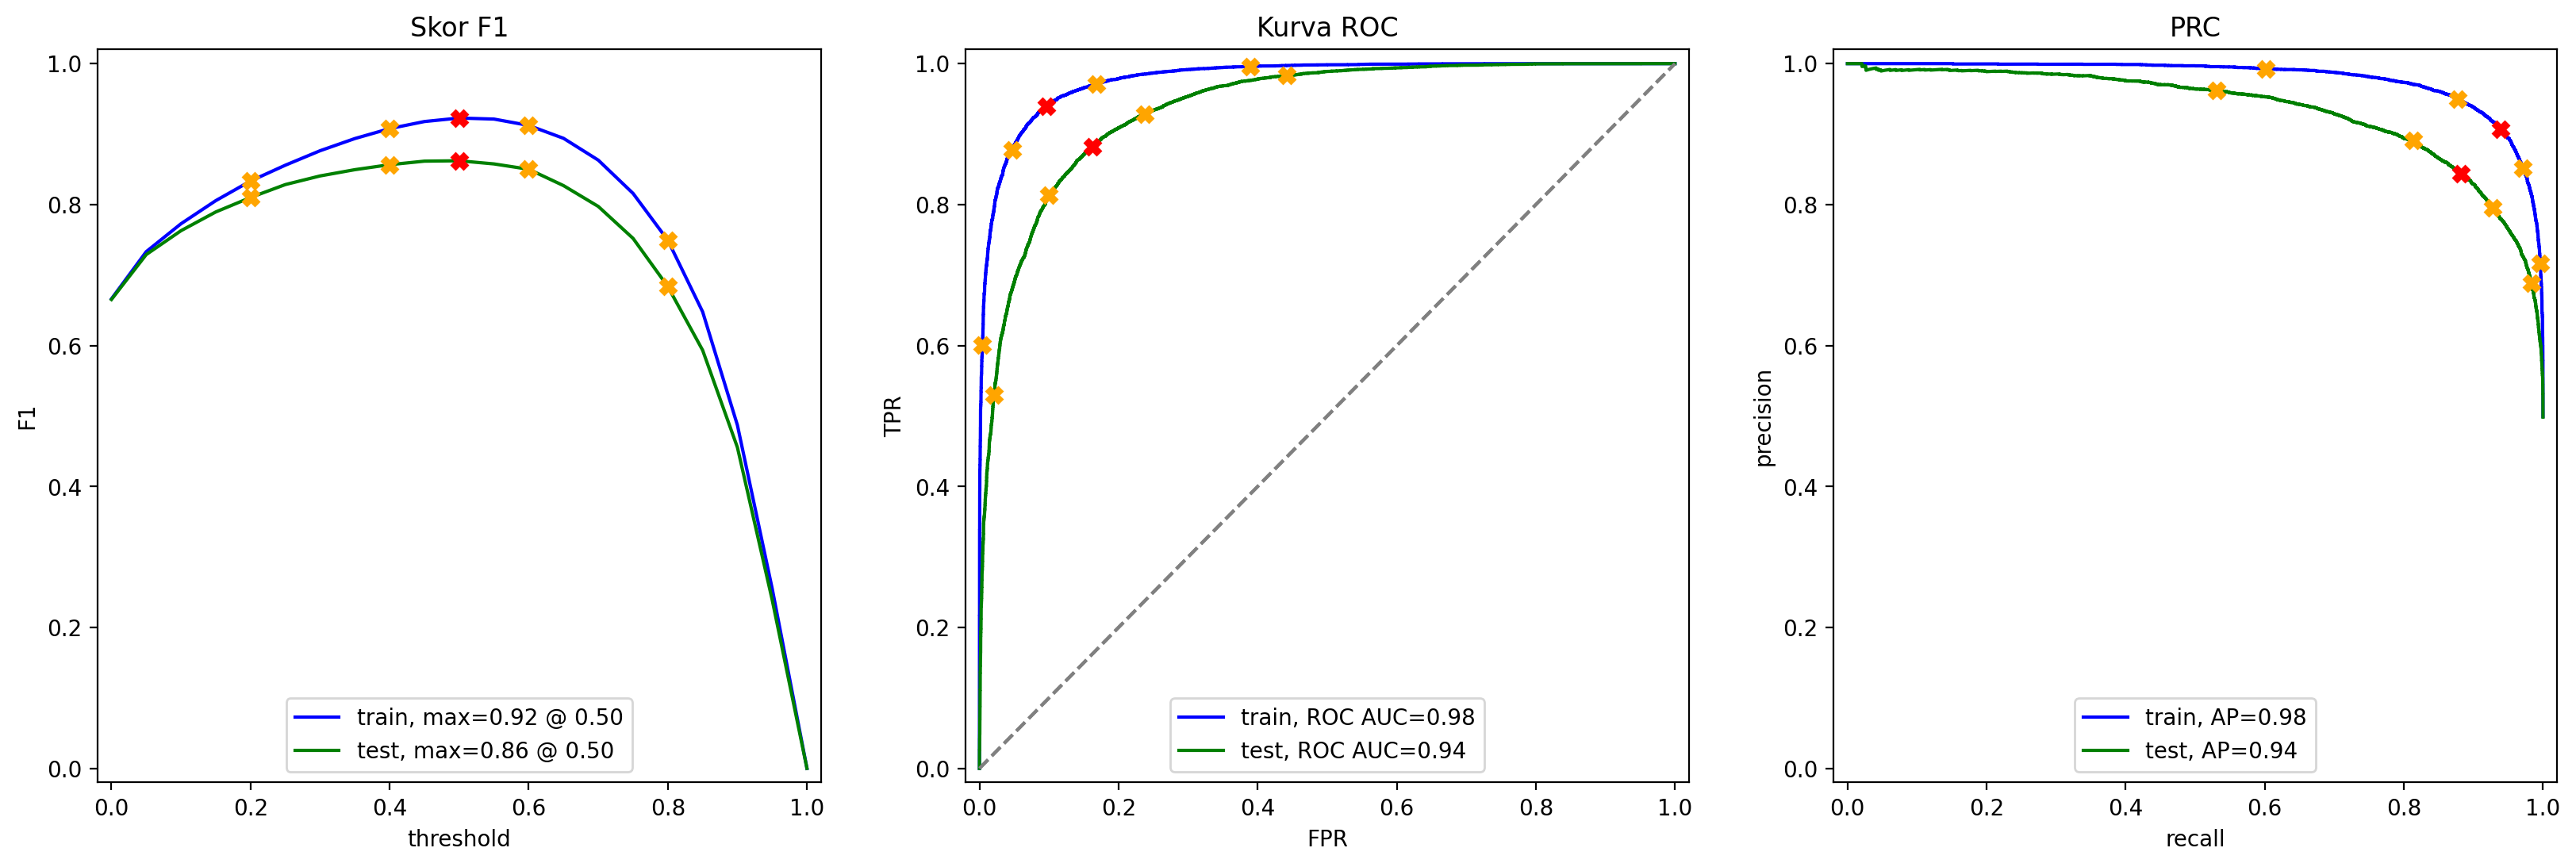

In [49]:
# Realizar la evaluación del modelo
model_7_score = evaluate_model(model_7, features_train_7, target_train, features_test_7, target_test)
model_7_score

Hasta ahora, el Modelo 1 sigue siendo el modelo con mejor rendimiento.

#### 7.8.2 Probando el Modelo 7 en Nuevos Datos de Prueba

In [50]:
# Calcular la puntuación de probabilidad basada en el modelo
my_reviews_pred_prob = model_7.predict_proba(tf_idf.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.22:  this movie was an absolute waste of time i wouldnt recommend it to anyone
0.76:  i was thoroughly impressed with this film the storyline was engaging and the acting was superb
0.26:  i found this movie to be incredibly boring it just didnt hold my attention
0.79:  the special effects in this movie were out of this world definitely worth watching
0.55:  i was disappointed by this film it didnt live up to the hype
0.72:  this movie was a masterpiece i was blown away by the stunning visuals and emotional storyline
0.30:  i thought the acting in this movie was terrible it was hard to watch
0.62:  i couldnt take my eyes off the screen this movie had me on the edge of my seat from start to finish
0.55:  the dialogue in this movie was so cheesy i couldnt take it seriously
0.89:  i loved this film it had all the right elements to make a great movie


Este modelo también carece de precisión al proporcionar valores de probabilidad. Hay un error en las líneas 5 y 9.

## 8 Conclusión

Hemos probado 7 modelos diferentes en el análisis actual. En general, todos los modelos proporcionaron una puntuación F1 superior a 0.85, como se esperaba para esta tarea. Sin embargo, hay variaciones en la calidad entre los modelos.

El `Modelo 1`, que se entrenó utilizando Regresión Logística con el método TF-IDF y la biblioteca NLTK para NLP, entregó la mejor puntuación general. Alcanzó una puntuación F1 de 0.88 en los datos de prueba.

In [51]:
# Unificar las variables de los modelos en un solo DataFrame
all_score = pd.concat([model_0_score, model_1_score, model_2_score, model_3_score, 
                       model_4_score, model_5_score, model_6_score, model_6_score], axis=1)

# Cambiar los índices a nombres de columna y convierte las columnas en filas
all_score = all_score.T.rename_axis('model').set_index(
    pd.Index(['model_0_train', 'model_0_test', 'model_1_train', 'model_1_test',
              'model_2_train', 'model_2_test', 'model_3_train', 'model_3_test', 
              'model_4_train', 'model_4_test', 'model_5_train', 'model_5_test',
              'model_6_train', 'model_6_test', 'model_7_train', 'model_7_test']))
model_name = ['Konstan', '^', 'NLTK LR', '^', 'spaCy LR', '^',  'NLTK LGBM', '^', 
              'spaCy LGBM', '^', 'NLTK XGBoost', '^', 'spaCy XGBoost', '^', 
             'NLTK Catboost', '^']
all_score.insert(0, 'Model', model_name)
all_score

,Model,Accuracy,F1,APS,ROC AUC
model_0_train,Konstan,0.50,0.67,0.50,0.50
model_0_test,^,0.50,0.67,0.50,0.50
model_1_train,NLTK LR,0.94,0.94,0.98,0.98
model_1_test,^,0.88,0.87,0.95,0.95
model_2_train,spaCy LR,0.93,0.93,0.98,0.98
model_2_test,^,0.87,0.87,0.94,0.95
model_3_train,NLTK LGBM,0.91,0.91,0.97,0.97
model_3_test,^,0.86,0.86,0.93,0.93
model_4_train,spaCy LGBM,0.91,0.91,0.97,0.97
model_4_test,^,0.85,0.85,0.93,0.93


### Resumen de Resultados
- **Modelos Evaluados**: Se evaluaron 7 modelos diferentes en total.
- **Puntuación F1**: Todos los modelos alcanzaron una puntuación F1 superior a 0.85, lo que indica un buen rendimiento general en la tarea.

### Detalle por Modelo

1. `Modelo 1 (NLTK LR)`:
   - **Mejor rendimiento**: Este modelo mostró el mejor desempeño general, con una puntuación F1 de 0.88 en los datos de prueba. 
   - **Precisión**: Alta precisión tanto en entrenamiento (0.94) como en prueba (0.88).
   - **Otras Métricas**: También destacó en APS (0.95) y ROC AUC (0.95) en los datos de prueba.

2. `Modelos de Regresión Logística (spaCy vs. NLTK)`:
   - **Modelo 2 (spaCy LR)**: Similar al Modelo 1 en términos de F1 (0.87 en prueba), pero ligeramente inferior.
   - **Modelo 3 (NLTK LGBM)** y **Modelo 4 (spaCy LGBM)**: Ambos mostraron resultados cercanos, pero el Modelo 3 tuvo un rendimiento ligeramente superior en los datos de prueba (F1 = 0.86 vs. 0.85).

3. `Modelos de XGBoost`:
   - **Modelo 5 (NLTK XGBoost)** y **Modelo 6 (spaCy XGBoost)**: Mostraron resultados similares, pero ambos tuvieron una puntuación F1 en prueba de 0.85.
   - **Modelo 7 (NLTK Catboost)**: También mostró un desempeño comparable a los modelos de XGBoost, con una puntuación F1 en prueba de 0.85.

### Conclusiones

- **Mejor Modelo**: El `Modelo 1 (NLTK LR)` fue el más efectivo en términos de puntuación F1 en los datos de prueba. Esto sugiere que la combinación de NLTK para el procesamiento del lenguaje natural y la regresión logística con TF-IDF es altamente efectiva para esta tarea específica.
  
- **Consistencia**: La mayoría de los modelos lograron puntuaciones similares en términos de precisión y F1 en prueba, con el Modelo 1 sobresaliendo ligeramente.

- **Modelo de Texto**: Los modelos que utilizan **NLTK** parecen tener una ligera ventaja sobre aquellos que usan **spaCy**, aunque las diferencias no son extremadamente grandes.

- **Variabilidad en Métricas**: La variación en métricas como APS y ROC AUC entre los modelos también sugiere que, aunque todos los modelos tienen un buen desempeño, el Modelo 1 combina bien las métricas para obtener una puntuación general superior.

En resumen, mientras todos los modelos son bastante buenos, el `Modelo 1 (NLTK LR)` es el que ofrece el mejor rendimiento global y podría ser el más recomendable para esta tarea.